In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import miner_py3 as miner

In [2]:
from importlib import reload
reload(miner)


<module 'miner_py3' from '/Users/mwall/Desktop/GitHub/miner/miner/src/miner_py3.py'>

In [3]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','GitHub','miner','miner')

# create name for results folder where output files will be saved
resultsFolder = "GSVA_results_2"

# name of the folder containing the miner network
#networkFolder = "miner_network_results"
networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [4]:
# Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table_path = os.path.join(os.path.expanduser("~"),"Desktop","GitHub","miner","miner","data","identifier_mappings.txt")
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

completed identifier conversion.
16216 genes were converted.


In [5]:
# Identify baseline and relapse patients
baseline_patients = [name for name in expressionData.columns if name.split("_")[2]=='1']
relapse_patients = [name for name in expressionData.columns if name.split("_")[2]=='2']
all_relapse_patients = [name for name in expressionData.columns if name.split("_")[2]!='1']
print('Baseline:',len(baseline_patients),'First relapse:',len(relapse_patients),'\nAny relapse:',len(all_relapse_patients))

Baseline: 779 First relapse: 56 
Any relapse: 102


## Load programs and states

In [6]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [7]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

In [8]:
states_df = pd.DataFrame(np.zeros((len(states),expressionData.shape[1])))
states_df.index = list(range(1,len(states)+1))
states_df.columns = expressionData.columns

for i in range(len(states)):
    states_df.loc[i+1,states[i]] = 1

states_df.head()

,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Load pathways enrichment matrix

In [155]:
#Read normalized enrichment scores for MSigDb pathways databases of each expression profile
pathways_mmrf = pd.read_csv(os.path.join(input_path,"data","expression","MMRF_Pathways.csv"),index_col=0,header=0)

In [1093]:
# Define two phenotypes for comparison
phenotype1 = baseline_patients
phenotype2 = relapse_patients

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_relapse = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)

# View top results
wilcoxon_relapse.tail(10)

,Statistic,p-value
REACTOME_NEUTROPHIL_DEGRANULATION,-5.202165,1.969800e-07
REACTOME_TCR_SIGNALING,-5.271573,1.352592e-07
KEGG_GLUTATHIONE_METABOLISM,-5.311153,1.089337e-07
REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES,-5.323199,1.019580e-07
REACTOME_TRANSLOCATION_OF_ZAP_70_TO_IMMUNOLOGICAL_SYNAPSE,-5.429893,5.638797e-08
KEGG_PENTOSE_PHOSPHATE_PATHWAY,-5.432761,5.548879e-08
NABA_ECM_AFFILIATED,-5.535439,3.104501e-08
REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION,-5.577887,2.434581e-08
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,-5.596816,2.183239e-08
REACTOME_PHOSPHORYLATION_OF_CD3_AND_TCR_ZETA_CHAINS,-5.696053,1.226131e-08


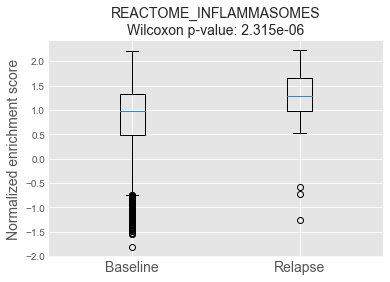

In [1098]:
# Select pathway for visualization
pthwy = "REACTOME_INFLAMMASOMES"
plt.boxplot([pathways_mmrf.loc[pthwy,phenotype1],
             pathways_mmrf.loc[pthwy,phenotype2]])

wrs = stats.ranksums(pathways_mmrf.loc[pthwy,phenotype1],
             pathways_mmrf.loc[pthwy,phenotype2])
plt.title(pthwy+'\nWilcoxon p-value: {:.3e}'.format(wrs[1]),FontSize=14)
plt.ylabel('Normalized enrichment score',fontsize=14)
_=plt.xticks([1, 2], ["Baseline","Relapse"],fontsize=14)

## Load survival data

In [40]:
guanSurvivalDfMMRF.head()

,duration,observed,kmEstimate,GuanScore
MMRF_2754_1_BM,8,1,0.998679,1.000000
MMRF_2151_1_BM,13,1,0.997358,0.998677
MMRF_1634_1_BM,16,1,0.994716,0.996683
MMRF_1450_1_BM,16,1,0.994716,0.996683
MMRF_1778_1_BM,19,1,0.993395,0.994709


In [39]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

In [1100]:
# Training and test set risk cut-offs
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20

# Define low- and high-risk patients
high_risk_MMRF = guanSurvivalDfMMRF.index[0:round(guanSurvivalDfMMRF.shape[0]*train_cut_high)]
low_risk_MMRF = guanSurvivalDfMMRF.index[round(guanSurvivalDfMMRF.shape[0]*train_cut_low):]


In [1102]:
# Analyze low-risk and high-risk phenotypes
phenotype1 = high_risk_MMRF
phenotype2 = low_risk_MMRF

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_risk = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)

# View top results
wilcoxon_risk.head(10)

,Statistic,p-value
REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX,7.339830,2.138659e-13
BIOCARTA_MCM_PATHWAY,7.336156,2.198153e-13
REACTOME_CELL_CYCLE_MITOTIC,7.278608,3.372816e-13
REACTOME_DNA_STRAND_ELONGATION,7.170246,7.486289e-13
KEGG_DNA_REPLICATION,7.091271,1.328860e-12
REACTOME_CHROMOSOME_MAINTENANCE,7.085761,1.382823e-12
KEGG_CELL_CYCLE,7.029437,2.073681e-12
REACTOME_CELL_CYCLE_CHECKPOINTS,6.988419,2.780012e-12
REACTOME_MITOTIC_G1_G1_S_PHASES,6.971277,3.140769e-12
REACTOME_G2_M_CHECKPOINTS,6.955972,3.501403e-12


## Subtype-specific risk (t(4;14) and Amp 1q)

In [1104]:
# Load mutation information
t414_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)

# Compare low-and high-risk within subtype
subtype = t414_patients
srv = guanSurvivalDfMMRF.loc[miner.intersect(subtype,guanSurvivalDfMMRF.index),:]
srv.sort_values(by="GuanScore",ascending=False,inplace=True)

# Split into low- and high-risk
# Training and test set risk cut-offs
train_cut_high = 0.30
train_cut_low = 0.70

# Define low- and high-risk patients
high_risk_subtype = srv.index[0:round(srv.shape[0]*train_cut_high)]
low_risk_subtype = srv.index[round(srv.shape[0]*train_cut_low):]

# Analyze low-risk and high-risk phenotypes
phenotype1 = high_risk_subtype
phenotype2 = low_risk_subtype

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_t414 = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)

# View top results
wilcoxon_t414.head(10)

,Statistic,p-value
REACTOME_COOPERATION_OF_PREFOLDIN_AND_TRIC_CCT_IN_ACTIN_AND_TUBULIN_FOLDING,4.825607,0.000001
REACTOME_PREFOLDIN_MEDIATED_TRANSFER_OF_SUBSTRATE_TO_CCT_TRIC,4.798110,0.000002
REACTOME_FORMATION_OF_TUBULIN_FOLDING_INTERMEDIATES_BY_CCT_TRIC,4.756866,0.000002
REACTOME_KINESINS,4.633132,0.000004
PID_MYC_ACTIV_PATHWAY,4.399413,0.000011
REACTOME_GAP_JUNCTION_ASSEMBLY,4.399413,0.000011
PID_FOXM1_PATHWAY,4.330673,0.000015
REACTOME_POST_CHAPERONIN_TUBULIN_FOLDING_PATHWAY,4.330673,0.000015
KEGG_PURINE_METABOLISM,4.248184,0.000022
KEGG_PYRIMIDINE_METABOLISM,4.193191,0.000028


In [1105]:
# Load mutation information
amp1q_patients = miner.getMutations("amp1q",cytogenetics)

# Compare low-and high-risk within subtype
subtype = amp1q_patients
srv = guanSurvivalDfMMRF.loc[miner.intersect(subtype,guanSurvivalDfMMRF.index),:]
srv.sort_values(by="GuanScore",ascending=False,inplace=True)

# Split into low- and high-risk
# Training and test set risk cut-offs
train_cut_high = 0.30
train_cut_low = 0.70

# Define low- and high-risk patients
high_risk_subtype = srv.index[0:round(srv.shape[0]*train_cut_high)]
low_risk_subtype = srv.index[round(srv.shape[0]*train_cut_low):]

# Analyze low-risk and high-risk phenotypes
phenotype1 = high_risk_subtype
phenotype2 = low_risk_subtype

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_amp1q = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)

# View top results
wilcoxon_amp1q.head(10)

,Statistic,p-value
REACTOME_MEIOSIS,5.363673,8.154664e-08
REACTOME_CHROMOSOME_MAINTENANCE,5.220300,1.786335e-07
REACTOME_RECRUITMENT_OF_NUMA_TO_MITOTIC_CENTROSOMES,5.194698,2.050527e-07
REACTOME_CELL_CYCLE_MITOTIC,5.179336,2.226766e-07
REACTOME_TELOMERE_MAINTENANCE,5.163975,2.417599e-07
REACTOME_RHO_GTPASES_ACTIVATE_FORMINS,5.158855,2.484652e-07
REACTOME_RHO_GTPASE_EFFECTORS,5.133252,2.847777e-07
REACTOME_CENTROSOME_MATURATION,5.107650,3.261900e-07
REACTOME_REPRODUCTION,5.087168,3.634493e-07
REACTOME_MITOTIC_PROPHASE,5.082048,3.733874e-07


## State-specific pathways

In [46]:
state_pathways_dfs = []
for i in range(len(states)):
    # Define two phenotypes for comparison
    phenotype1 = states[i]
    phenotype2 = miner.setdiff(pathways_mmrf.columns,phenotype1)

    # Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
    wilcoxon_state = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)
    
    # Append enrichment information to list
    state_pathways_dfs.append(wilcoxon_state)

    print('completed iteration {:d}'.format(i+1))



completed iteration 1
completed iteration 2
completed iteration 3
completed iteration 4
completed iteration 5
completed iteration 6
completed iteration 7
completed iteration 8
completed iteration 9
completed iteration 10
completed iteration 11
completed iteration 12
completed iteration 13
completed iteration 14
completed iteration 15
completed iteration 16
completed iteration 17
completed iteration 18
completed iteration 19
completed iteration 20
completed iteration 21
completed iteration 22
completed iteration 23
completed iteration 24
completed iteration 25
completed iteration 26


In [77]:
# Write dfs to files
for i in range(len(states)):
    state_pathways_dfs[i].to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"pathways.csv"])))

In [1106]:
# Investigate state-specific results
state_pathways_dfs[14].head(25)

,Statistic,p-value
KEGG_CELL_CYCLE,7.628921,2.367260e-14
REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX,7.574429,3.607105e-14
REACTOME_RHO_GTPASES_ACTIVATE_FORMINS,7.565483,3.864274e-14
REACTOME_EXTENSION_OF_TELOMERES,7.563856,3.912932e-14
REACTOME_COOPERATION_OF_PREFOLDIN_AND_TRIC_CCT_IN_ACTIN_AND_TUBULIN_FOLDING,7.553283,4.244221e-14
KEGG_PYRIMIDINE_METABOLISM,7.534576,4.899223e-14
REACTOME_SUMOYLATION_OF_DNA_REPLICATION_PROTEINS,7.511804,5.831825e-14
REACTOME_CELL_CYCLE_MITOTIC,7.497977,6.481019e-14
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,7.493097,6.726702e-14
PID_AURORA_B_PATHWAY,7.475204,7.708402e-14


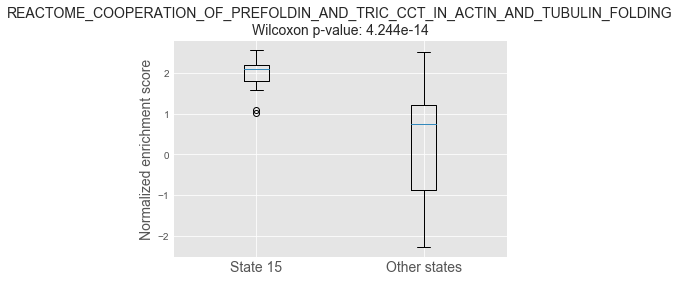

In [1110]:
# Select pathway for visualization
pthwy = "REACTOME_COOPERATION_OF_PREFOLDIN_AND_TRIC_CCT_IN_ACTIN_AND_TUBULIN_FOLDING"

#Define phenotypes
state_ix = 14
phenotype1 = states[state_ix]
phenotype2 = miner.setdiff(pathways_mmrf.columns,phenotype1)

#Calculate significance of differential expression
wrs = stats.ranksums(pathways_mmrf.loc[pthwy,phenotype1],
             pathways_mmrf.loc[pthwy,phenotype2])

#Generate boxplot
plt.boxplot([pathways_mmrf.loc[pthwy,phenotype1],
             pathways_mmrf.loc[pthwy,phenotype2]])
plt.title(pthwy+'\nWilcoxon p-value: {:.3e}'.format(wrs[1]),FontSize=14)
plt.ylabel('Normalized enrichment score',fontsize=14)
_=plt.xticks([1, 2], ["State "+str(state_ix+1),"Other states"],fontsize=14)

## Compare program activities across states

In [47]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes

In [78]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = pr_genes
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedProgramsMatrix_pr = miner.membershipToIncidence(overExpressedMembers_pr,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedProgramsMatrix_pr = miner.membershipToIncidence(underExpressedMembers_pr,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

done!
done!


In [79]:
dfr_pr = overExpressedProgramsMatrix_pr - underExpressedProgramsMatrix_pr

In [50]:
# Get eigengenes for all modules
eigengenes_pr = miner.getEigengenes(pr_genes,expressionData,regulon_dict=None,saveFolder=None)
eigenScale_pr = np.percentile(expressionData,95)/np.percentile(eigengenes_pr,95)
eigengenes_pr = eigenScale_pr*eigengenes_pr
eigengenes_pr.index = np.array(eigengenes_pr.index).astype(int)
#write eigengenes to .csv
eigengenes_pr.to_csv(os.path.join(resultsDirectory,"eigengenes_pr.csv"))


Text(0.5, 1.0, 'Program eigengenes')

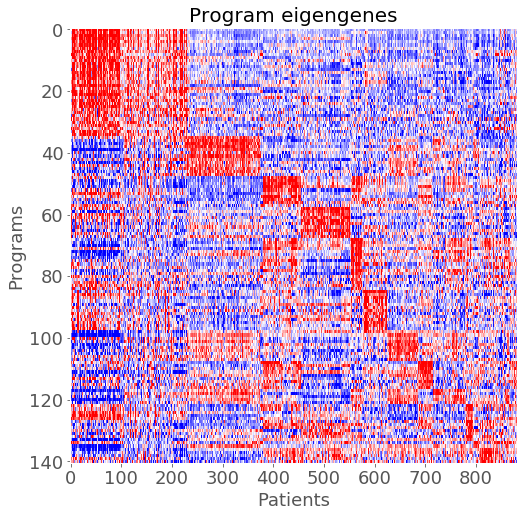

In [91]:
#Plot program eigengenes
plt.figure(figsize=(8,8))
plt.imshow(eigengenes_pr.loc[:,np.hstack(states)],cmap="bwr",aspect="auto",vmin=-1.5,vmax=1.5)
plt.grid(False)
plt.ylabel("Programs",fontsize=18)
plt.xlabel("Patients",fontsize=18)
_=plt.yticks(fontsize=18)
_=plt.xticks(fontsize=18)
plt.title("Program eigengenes",fontsize=20)

Text(0.5, 1.0, 'Program activity')

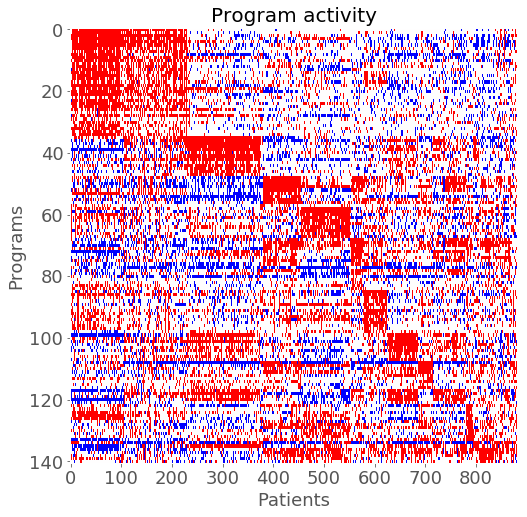

In [92]:
#Plot program activity
plt.figure(figsize=(8,8))
plt.imshow(dfr_pr.loc[:,np.hstack(states)],cmap="bwr",aspect="auto")
plt.grid(False)
plt.ylabel("Programs",fontsize=18)
plt.xlabel("Patients",fontsize=18)
_=plt.yticks(fontsize=18)
_=plt.xticks(fontsize=18)
plt.title("Program activity",fontsize=20)

In [186]:
program_ix = 68
mean_eigengene = []
mean_activity = []
wilcoxon_eigengene = []
wilcoxon_activity = []
guanrisk_mean = []
for s in range(len(states)):
    phenotype1 = states[s]
    phenotype2 = miner.setdiff(np.hstack(states),phenotype1)
    tmp_activity = np.mean(dfr_pr.loc[program_ix,phenotype1])
    tmp_eigengene = np.mean(eigengenes_pr.loc[program_ix,phenotype1])
    tmp_wilcox_activity = stats.ranksums(dfr_pr.loc[program_ix,phenotype1],dfr_pr.loc[program_ix,phenotype2])
    tmp_wilcox_eigengene = stats.ranksums(eigengenes_pr.loc[program_ix,phenotype1],eigengenes_pr.loc[program_ix,phenotype2])
    tmp_pats = miner.intersect(phenotype1,guanSurvivalDfMMRF.index)
    tmp_guan = 0
    if len(tmp_pats) >= 3:
        tmp_guan = guanSurvivalDfMMRF.loc[tmp_pats,"GuanScore"].mean()
         
    # Append to lists
    mean_eigengene.append(tmp_eigengene)
    mean_activity.append(tmp_activity)
    wilcoxon_eigengene.append(tmp_wilcox_eigengene)
    wilcoxon_activity.append(tmp_wilcox_activity)
    guanrisk_mean.append(tmp_guan)
    

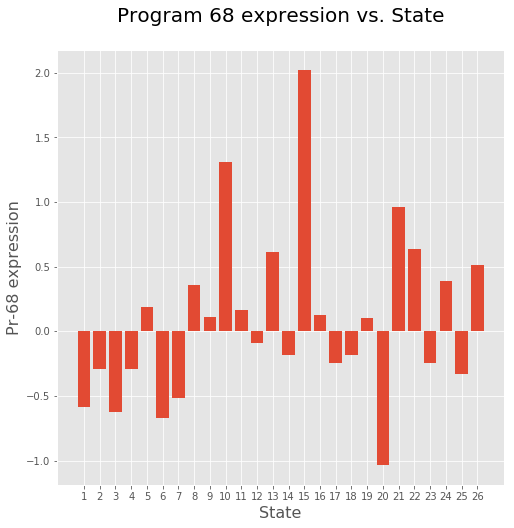

In [187]:
wilcoxon_eigengene_stat = [wilcoxon_eigengene[i][0] for i in range(len(wilcoxon_eigengene))]
plt.figure(figsize=(8,8))
plt.bar(np.arange(len(mean_eigengene)),mean_eigengene)
plt.ylabel("Pr-68 expression",fontsize=16)
plt.xlabel("State",fontsize=16)
_=plt.xticks(np.arange(len(mean_eigengene)),labels=np.arange(1,len(mean_eigengene)+1))
plt.title("Program 68 expression vs. State\n",fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"Pr_68_eigengene_vs_state.pdf"),bbox_inches="tight")

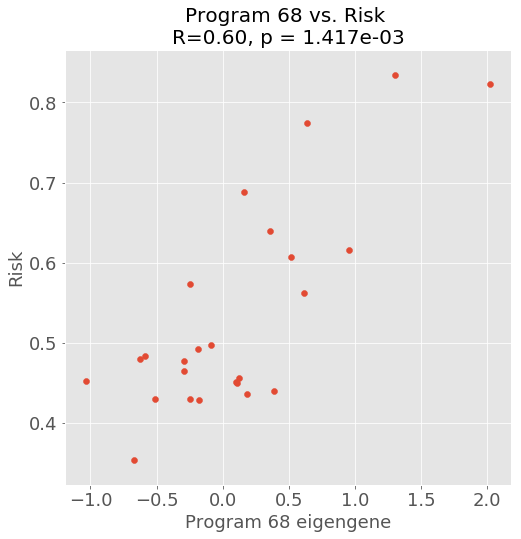

In [188]:
#Program 68 eigengene vs risk
plt.figure(figsize=(8,8))
plt.scatter(np.array(mean_eigengene)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
r,p = stats.spearmanr(np.array(mean_eigengene)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
plt.ylabel("Risk",fontsize=18)
plt.xlabel("Program 68 eigengene",fontsize=18)
_=plt.yticks(fontsize=18)
_=plt.xticks(fontsize=18)
plt.title("Program 68 vs. Risk \nR={:.2f}, p = {:.3e}".format(r,p),fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"Pr_68_eigengene_vs_risk.pdf"),bbox_inches="tight")

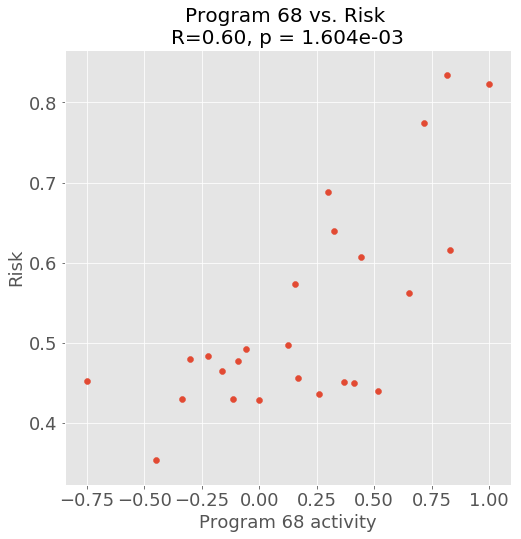

In [189]:
#Program 68 activity vs risk
plt.figure(figsize=(8,8))
plt.scatter(np.array(mean_activity)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
r,p = stats.spearmanr(np.array(mean_activity)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
plt.ylabel("Risk",fontsize=18)
plt.xlabel("Program 68 activity",fontsize=18)
_=plt.yticks(fontsize=18)
_=plt.xticks(fontsize=18)
plt.title("Program 68 vs. Risk \nR={:.2f}, p = {:.3e}".format(r,p),fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"Pr_68_activity_vs_risk.pdf"),bbox_inches="tight")

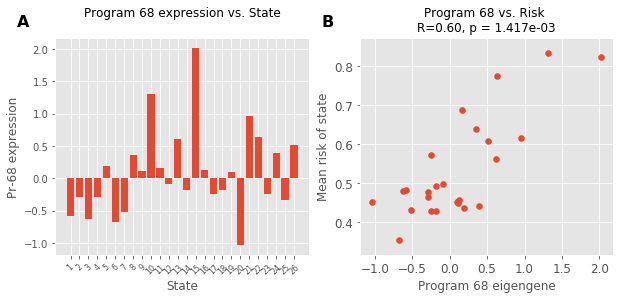

In [202]:
#Summary figure
fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(10)

#bar plot
plt.sca(axs[0])
plt.bar(np.arange(len(mean_eigengene)),mean_eigengene)
plt.ylabel("Pr-68 expression",fontsize=12)
plt.xlabel("State",fontsize=12)
_=plt.xticks(np.arange(len(mean_eigengene)),
             labels=np.arange(1,len(mean_eigengene)+1),
            fontsize=8,rotation=45)
plt.title("Program 68 expression vs. State\n",fontsize=12)

#scatter plot
plt.sca(axs[1])
plt.scatter(np.array(mean_eigengene)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
r,p = stats.spearmanr(np.array(mean_eigengene)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
plt.ylabel("Mean risk of state",fontsize=12)
plt.xlabel("Program 68 eigengene",fontsize=12)
_=plt.yticks(fontsize=12)
_=plt.xticks(fontsize=12)
plt.title("Program 68 vs. Risk \nR={:.2f}, p = {:.3e}".format(r,p),fontsize=12)

#Add letters
import string
for n, ax in enumerate(axs):  
    ax.text(-0.15, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

#Save figure
plt.savefig(os.path.join(resultsDirectory,"Pr68_risk_plots.pdf"),bbox_inches='tight')


## Compare Pr-68 to cell cycle signature

In [ ]:
#Pick top 2 correlation signatures, plot km plots of top 2 + Pr-68

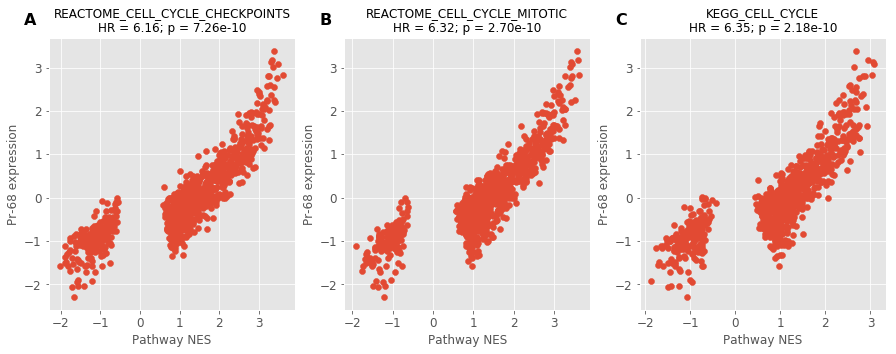

In [185]:
terms = ["REACTOME_CELL_CYCLE_CHECKPOINTS",
         "REACTOME_CELL_CYCLE_MITOTIC",
         "KEGG_CELL_CYCLE"]
         
#Instantiate figure
fig, axs = plt.subplots(1,len(terms))
fig.set_figheight(5)
fig.set_figwidth(15)

for i in range(len(terms)):
    term = terms[i]
    #Format pathway enrichments for survival analysis
    input_df = pd.DataFrame(pathways_mmrf.loc[term,:].T)
    input_df = input_df.loc[guanSurvivalDfMMRF.index,:]

    #Perform Cox Hazards regression
    tmp_surv_results = miner.survivalMedianAnalysisDirect(input_df,guanSurvivalDfMMRF.copy())
    tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
    tmp_surv_df.columns = ["HR","p"]
    tmp_surv_df.index = [term]
    #print(tmp_surv_df)

    #Plot results
    plt.sca(axs[i])
    plt.scatter(pathways_mmrf.loc[term,:],eigengenes_pr.loc[program_id,pathways_mmrf.columns])

    title_str = term+'\nHR = '+'{:.2f}'.format(
        tmp_surv_df.loc[term,"HR"])+';'+' p = '+'{:.2e}'.format(
        tmp_surv_df.loc[term,"p"])

    plt.title(title_str,fontsize=12)
    plt.xlabel("Pathway NES",fontsize=12)
    plt.ylabel("Pr-68 expression",fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

#Add letters
for n, ax in enumerate(axs):  
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

#Save figure
plt.savefig(os.path.join(resultsDirectory,"Pr68_cell_cycle.pdf"),bbox_inches='tight')

In [171]:
print('HR = '+'{:.2f}'.format(tmp_surv_df.loc[term,"HR"])+';'+
' p = '+'{:.2e}'.format(tmp_surv_df.loc[term,"p"]))

HR = 6.16; p = 7.26e-10


## Perform Cox regression on programs

In [1037]:
# Cox proportional hazards regression of transcriptional programs
t1 = time.time()

cox_programs_output = miner.parallelMedianSurvivalAnalysis(pr_genes,expressionData,guanSurvivalDfMMRF,numCores=5)
cox_programs_output = cox_programs_output.iloc[np.argsort(np.array(cox_programs_output.index).astype(int))]
cox_programs_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsPrograms.csv'))
cox_programs_output.sort_values(by="HR",ascending=False,inplace=True)

print("\nHigh-risk regulons:")
print(cox_programs_output.iloc[0:5,:])
print("\nLow-risk regulons")
print(cox_programs_output.iloc[-5:,:])

t2 = time.time()
print("Completed regulon risk analysis in {:.2f} minutes".format((t2-t1)/60.))


Completed 0 of 28 iterations
Completed 0 of 28 iterations
Completed 0 of 28 iterations
Completed 0 of 28 iterations
Completed 0 of 29 iterations

High-risk regulons:
          HR       p-value
68  8.811208  1.238043e-18
71  7.246735  4.269397e-13
69  6.862449  6.768991e-12
76  6.464156  1.018661e-10
54  6.404907  1.504607e-10

Low-risk regulons
           HR       p-value
36  -4.053011  5.056267e-05
26  -4.163220  3.137904e-05
110 -4.237206  2.263185e-05
61  -4.652298  3.282561e-06
104 -5.929361  3.041155e-09
Completed regulon risk analysis in 0.15 minutes


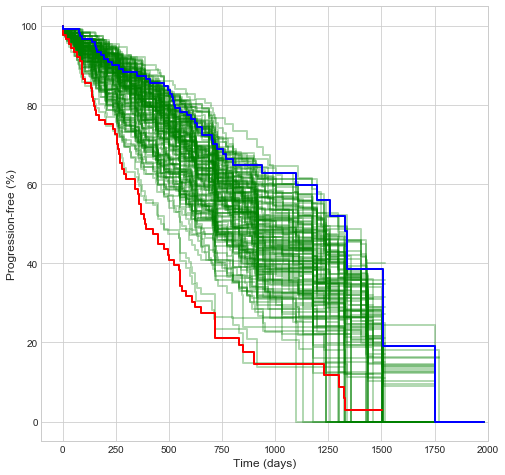

In [1038]:
# Kaplan-Meier plot of all programs (median expression)
srv = guanSurvivalDfMMRF.copy()
keys = list(pr_genes.keys())

plt.figure(figsize=(8,8))
plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)
for key in keys:
    cluster = np.array(expressionData.loc[pr_genes[key],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    membership_df = pd.DataFrame(median_)
    membership_df.index = expressionData.columns
    membership_df.columns = [key]

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

    groups = [membership_df.index[np.where(membership_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="gray",alpha=0.3)  


key_min = cox_programs_output.index[0]
key_max = cox_programs_output.index[-1]

cluster = np.array(expressionData.loc[pr_genes[key_min],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_min]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_min]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="red",alpha=1)  

    
cluster = np.array(expressionData.loc[pr_genes[key_max],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_max]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_max]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="blue",alpha=1) 

plt.savefig(os.path.join(resultsDirectory,"kmplots_programs.pdf"),bbox_inches="tight")

## Correlate program eigengenes to pathway enrichments

In [1040]:
pathway_results_dictionary = os.path.join(resultsDirectory,"pathway_correlations")
if not os.path.isdir(pathway_results_dictionary):
    os.mkdir(pathway_results_dictionary)
    
pathways_reference = pathways_mmrf
program_reference = eigengenes_pr
positive_only = False

for program_id in program_reference.index:

    pathway_rs = []
    pathway_ps = []
    for term in pathways_mmrf.index:
        if positive_only is True:
            tmp_patients = list(pathways_reference.columns[pathways_reference.loc[term,:]>0])
            r, p = stats.spearmanr(pathways_reference.loc[term,tmp_patients],
                           program_reference.loc[program_id,tmp_patients])
            pathway_rs.append(r)
            pathway_ps.append(p)

        elif positive_only is False:
            r, p = stats.spearmanr(pathways_reference.loc[term,:],
                               program_reference.loc[program_id,pathways_reference.columns])
            pathway_rs.append(r)
            pathway_ps.append(p)

    pathway_correlation = pd.DataFrame(np.vstack([pathway_rs,pathway_ps]).T)
    pathway_correlation.columns = ["R","p"]
    pathway_correlation.index = pathways_mmrf.index
    pathway_correlation.sort_values(by="R",ascending=False,inplace=True)


    #Define output directory to save optimized model
    output_dir = os.path.join(pathway_results_dictionary,str(program_id))
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    #Write model to file
    tmp_output = pathway_correlation[pathway_correlation.p < 0.05]
    tmp_output.to_csv(os.path.join(output_dir,"pathway_correlations.csv"))
    
    if int(program_id)%10==0:
        print("completed iteration {:d}".format(int(program_id)+1))


completed iteration 1
completed iteration 11
completed iteration 21
completed iteration 31
completed iteration 41
completed iteration 51
completed iteration 61
completed iteration 71
completed iteration 81
completed iteration 91
completed iteration 101
completed iteration 111
completed iteration 121
completed iteration 131
completed iteration 141


## Probe specific programs for pathway correlation

In [1471]:
program_id = 61
output_dir = os.path.join(pathway_results_dictionary,str(program_id))
pathway_correlation_61 = pd.read_csv(os.path.join(output_dir,"pathway_correlations.csv"),index_col=0,header=0)

program_id = 72
output_dir = os.path.join(pathway_results_dictionary,str(program_id))
pathway_correlation_72 = pd.read_csv(os.path.join(output_dir,"pathway_correlations.csv"),index_col=0,header=0)

program_id = 73
output_dir = os.path.join(pathway_results_dictionary,str(program_id))
pathway_correlation_73 = pd.read_csv(os.path.join(output_dir,"pathway_correlations.csv"),index_col=0,header=0)

miner.intersect(miner.intersect(pathway_correlation_72.index[0:20],
                pathway_correlation_73.index[0:20]),
                pathway_correlation_61.index[-20:])


['PID_MYC_ACTIV_PATHWAY', 'KEGG_PYRIMIDINE_METABOLISM']

In [ ]:
pathway_correlation_73

Text(0, 0.5, 'Mean(Pr-72, Pr-73)')

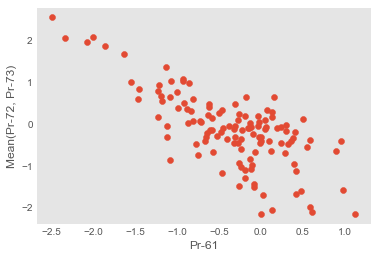

In [1479]:
plt.scatter(eigengenes_pr.loc[61,t414_patients],
           eigengenes_pr.loc[[72,73],t414_patients].mean(axis=0))
plt.grid(False)
plt.xlabel("Pr-61")
plt.ylabel("Mean(Pr-72, Pr-73)")

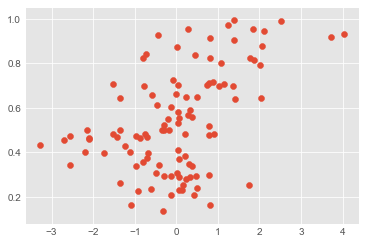

In [1484]:
t4p = t414_srv.index
plt.scatter(eigengenes_pr.loc[[72,73],t4p].mean(axis=0)-eigengenes_pr.loc[61,t4p],
            guanSurvivalDfMMRF.loc[t4p,"GuanScore"])

In [153]:
pathway_results_dictionary = os.path.join(os.path.split(os.getcwd())[0],"GSVA_results","pathway_correlations")
program_id = 68
output_dir = os.path.join(pathway_results_dictionary,str(program_id))
pathway_correlation = pd.read_csv(os.path.join(output_dir,"pathway_correlations.csv"),index_col=0,header=0)

pathway_correlation.head(25)

,R,p
PID_AURORA_B_PATHWAY,0.925296,0.000000e+00
REACTOME_MITOTIC_SPINDLE_CHECKPOINT,0.916381,0.000000e+00
REACTOME_POLO_LIKE_KINASE_MEDIATED_EVENTS,0.912907,0.000000e+00
REACTOME_CELL_CYCLE_CHECKPOINTS,0.903642,0.000000e+00
REACTOME_G1_S_SPECIFIC_TRANSCRIPTION,0.902946,0.000000e+00
REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX,0.901627,3.359646e-322
REACTOME_ACTIVATION_OF_ATR_IN_RESPONSE_TO_REPLICATION_STRESS,0.898173,5.757325e-316
REACTOME_CELL_CYCLE_MITOTIC,0.889158,1.117301e-300
REACTOME_DNA_STRAND_ELONGATION,0.884540,2.363981e-293
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,0.881086,4.481777e-288


                                 HR         p
KEGG_PYRIMIDINE_METABOLISM  3.67931  0.000234


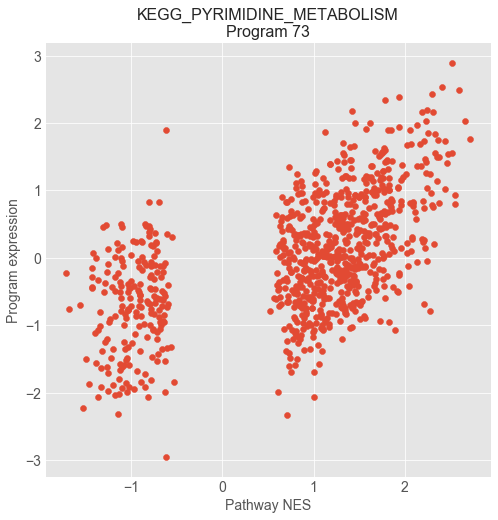

In [1488]:
term = "KEGG_PYRIMIDINE_METABOLISM"#"KEGG_CELL_CYCLE" #pathway_correlation.index[0]

plt.figure(figsize=(8,8))
plt.scatter(pathways_mmrf.loc[term,:],eigengenes_pr.loc[program_id,pathways_mmrf.columns])
plt.title(term+"\nProgram "+str(program_id),fontsize=16)
plt.xlabel("Pathway NES",fontsize=14)
plt.ylabel("Program expression",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#Format pathway enrichments for survival analysis
input_df = pd.DataFrame(pathways_mmrf.loc[term,:].T)
input_df = input_df.loc[guanSurvivalDfMMRF.index,:]

#Perform Cox Hazards regression
tmp_surv_results = miner.survivalMedianAnalysisDirect(input_df,guanSurvivalDfMMRF.copy())
tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
tmp_surv_df.columns = ["HR","p"]
tmp_surv_df.index = [term]
print(tmp_surv_df)

## PPI network benchmarking

In [67]:
# Path to the scenic directory
scenic_path = os.path.join(os.path.expanduser('~'),'Desktop','scenic','results')

#Read clusters identified by differential expression + STRING analysis
ppi_clusters = pd.read_csv(os.path.join(scenic_path,'MINER','string_MCL_clusters.tsv'),sep='\t')
# Cluster 1
ppi_cluster_1 = list(ppi_clusters[ppi_clusters["cluster number"]==1]["protein name"])
ppi_cluster_1_ens = miner.gene_conversion(ppi_cluster_1,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)
# Cluster 2
ppi_cluster_2 = list(ppi_clusters[ppi_clusters["cluster number"]==2]["protein name"])
ppi_cluster_2_ens = miner.gene_conversion(ppi_cluster_2,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)
# Cluster 3
ppi_cluster_3 = list(ppi_clusters[ppi_clusters["cluster number"]==3]["protein name"])
ppi_cluster_3_ens = miner.gene_conversion(ppi_cluster_3,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)

#Format as dictionary
ppi_cluster_dict = {1:ppi_cluster_1_ens,
                   2:ppi_cluster_2_ens,
                   3:ppi_cluster_3_ens}

# Get eigengenes for all modules
eigengenes_ppi = miner.getEigengenes(ppi_cluster_dict,expressionData,regulon_dict=None,saveFolder=None)
eigenScale_ppi = np.percentile(expressionData,95)/np.percentile(eigengenes_ppi,95)
eigengenes_ppi = eigenScale_ppi*eigengenes_ppi
eigengenes_ppi.index = np.array(eigengenes_ppi.index).astype(int)

#Format pathway enrichments for survival analysis
input_df = pd.DataFrame(eigengenes_ppi.loc[1,:].T)
input_df = input_df.loc[guanSurvivalDfMMRF.index,:]

#Perform Cox Hazards regression
tmp_surv_results = miner.survivalMedianAnalysisDirect(input_df,guanSurvivalDfMMRF.copy())
tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
tmp_surv_df.columns = ["HR","p"]
tmp_surv_df.index = ["PPI cluster 1"]
print(tmp_surv_df)

#Perform Cox Hazards regression
tmp_surv_results = miner.survivalMedianAnalysisDirect(pd.DataFrame(eigengenes_pr.loc[68,guanSurvivalDfMMRF.index].T),guanSurvivalDfMMRF.copy())
tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
tmp_surv_df.columns = ["HR","p"]
tmp_surv_df.index = ["Pr-68"]
print(tmp_surv_df)

                     HR             p
PPI cluster 1  8.163517  3.254072e-16
             HR             p
Pr-68  8.559045  1.138066e-17


In [73]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = ppi_cluster_dict
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_ppi = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_ppi = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedProgramsMatrix_ppi = miner.membershipToIncidence(overExpressedMembers_ppi,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedProgramsMatrix_ppi = miner.membershipToIncidence(underExpressedMembers_ppi,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

done!
done!


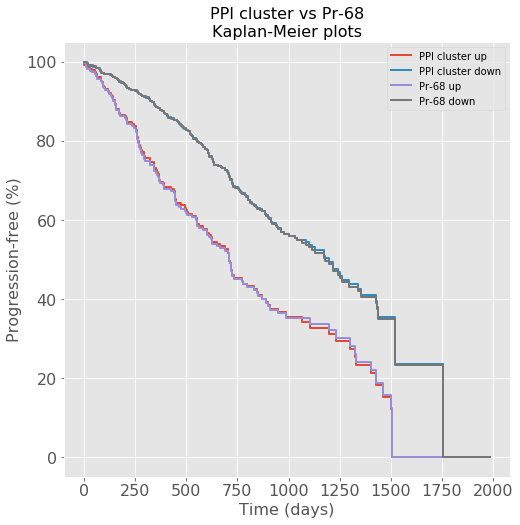

In [102]:
reload(miner)
#PPI cluster 1
ppi_1_up = overExpressedProgramsMatrix_ppi.columns[
    np.where(overExpressedProgramsMatrix_ppi.loc[1,:]==1)[0]
]
ppi_1_dn = miner.setdiff(overExpressedProgramsMatrix_ppi.columns,ppi_1_up)

#Program-68
pr68_up = overExpressedProgramsMatrix_pr.columns[
    np.where(overExpressedProgramsMatrix_pr.loc[68,:]==1)[0]
]
pr68_dn = miner.setdiff(overExpressedProgramsMatrix_pr.columns,pr68_up)

#KM plot
groups = [ppi_1_up,ppi_1_dn,pr68_up,pr68_dn]
labels = ["PPI cluster up","PPI cluster down",
         "Pr-68 up","Pr-68 down"]
plt.figure(figsize=(8,8))
gg = miner.kmplot(srv=guanSurvivalDfMMRF.copy(),groups=groups,
             labels=labels,legend=True,
             xlim_=(-100,1750),fs=16,lw=2,alpha=1,
             title="PPI cluster vs Pr-68\nKaplan-Meier plots",
             filename=os.path.join(resultsDirectory,"kmplots_ppi_pr68.pdf")) 

#plt.savefig(os.path.join(resultsDirectory,"kmplots_ppi_pr68.pdf"),bbox_inches="tight")

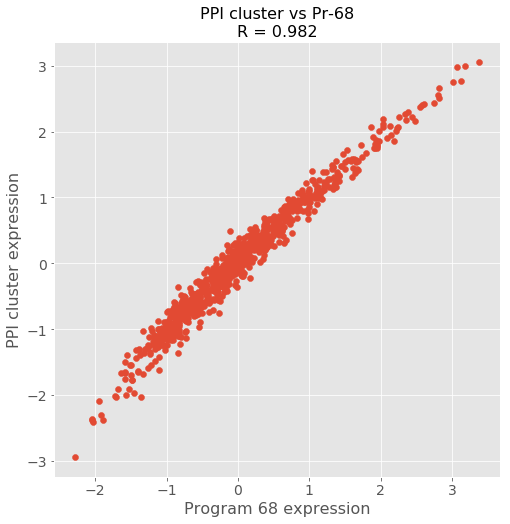

In [89]:
r,p = stats.spearmanr(eigengenes_pr.loc[68,:],eigengenes_ppi.loc[1,:])

plt.figure(figsize=(8,8))
plt.scatter(eigengenes_pr.loc[68,:],eigengenes_ppi.loc[1,:])
plt.title("PPI cluster vs Pr-68\nR = "+repr(round(r,3)),fontsize=16)
plt.xlabel("Program 68 expression",fontsize=16)
plt.ylabel("PPI cluster expression",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(resultsDirectory,"PPI_cluster_vs_Pr68.pdf"),bbox_inches="tight")

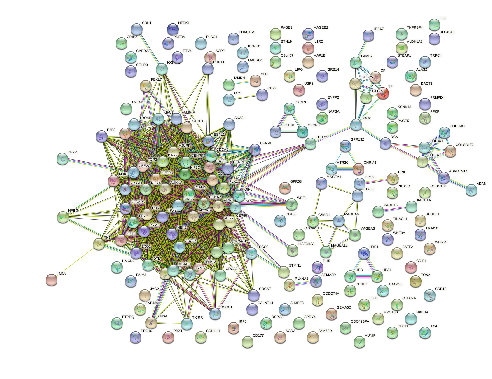

In [101]:
plt.figure(figsize=(8,8))
img1 = plt.imread(os.path.join(scenic_path,'MINER','string_normal_image.png'))
plt.imshow(img1)
plt.grid(False)
plt.axis('off')
plt.savefig(os.path.join(resultsDirectory,"test.png"),dpi=400)

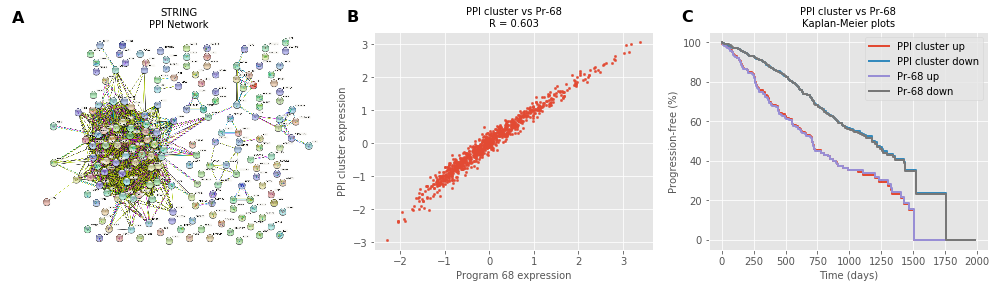

In [262]:
#Plot regulon maps side-by-side
# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(17)

#Scenic regulon activity
plt.sca(ax1)
plt.imshow(img1)
plt.grid(False)
plt.axis('off')
plt.title("STRING\nPPI Network",fontsize=10)

#MINER regulon eigengenes
plt.sca(ax2)
plt.scatter(eigengenes_pr.loc[68,:],eigengenes_ppi.loc[1,:],s=5)
plt.title("PPI cluster vs Pr-68\nR = "+repr(round(r,3)),fontsize=10)
plt.xlabel("Program 68 expression",fontsize=10)
plt.ylabel("PPI cluster expression",fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#MINER regulon activity
plt.sca(ax3)
miner.kmplot(srv=guanSurvivalDfMMRF.copy(),groups=groups,
             labels=labels,legend=True,
             xlim_=(-100,1750),fs=10,lw=2,alpha=1,
             title="PPI cluster vs Pr-68\nKaplan-Meier plots",
             filename=None)


#Add letters
import string
axs = [ax1,ax2,ax3]
for n, ax in enumerate(axs):  
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

#Save figure
plt.savefig(os.path.join(resultsDirectory,"PPI_Pr68_comparison.png"),dpi=400,bbox_inches="tight")

## Test program activity change as a function of binary variables (e.g., mutation status)

In [ ]:
#We want to capture the interaction of multiple features in predicting risk.
#Examples include the activity of more than 1 program, or the activity of a program in a given state.
#We are trying to predict risk. We want to know if performace can be improved by interaction terms.
#We want to quantify the improved performance with a p-value.


#target variable = GuanScore

#model a
#variable 1 = program 1 activity
#covariate = program 2 activity

#model b
#variable 1 = state
#covariate = program 1 activity

#model c
#variable 1 = program 1 activity
#covariate = state

#model d
#variable 1 = mutation
#covariates = programs

## model a -- split population by pr 1 activity into 2-3 groups. 
#Within each subgroup, use second variable to perform statistical test.
#Spearman correlation for continuous variables, chi-square or ranksums for categorical.

## alternative -- use decision tree regression and control for interaction terms by tree depth

## Try both.

In [ ]:
#survival_df, reference_matrix, primary_variable, covariates, primary_type, covariate_type

In [700]:
miner.getMutations(68,overExpressedProgramsMatrix_pr)

Index(['MMRF_2644_1_BM', 'MMRF_2313_1_BM', 'MMRF_1936_1_BM', 'MMRF_2720_1_BM',
       'MMRF_2217_1_BM', 'MMRF_2328_1_BM', 'MMRF_2458_1_BM', 'MMRF_1506_1_BM',
       'MMRF_1792_1_BM', 'MMRF_1518_3_BM',
       ...
       'MMRF_1981_1_BM', 'MMRF_1579_1_BM', 'MMRF_1079_1_BM', 'MMRF_1992_1_BM',
       'MMRF_1223_2_BM', 'MMRF_2384_1_BM', 'MMRF_1689_1_BM', 'MMRF_1296_1_BM',
       'MMRF_2125_1_BM', 'MMRF_1374_1_BM'],
      dtype='object', length=295)

In [783]:
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
target.mean()

0.5000103205564849

In [215]:
def combinatorial_risk(target,reference_matrix,covariate_matrix,primary_variable,min_group_size=5,min_mean_size=10,sort=True,target_type="continuous"):

    #Determine primary variable type
    indicator = len(set(reference_matrix.loc[primary_variable,:]))
    if indicator == 2:
        primary_type = "binary"
    elif indicator >2:
        primary_type = "categorical"

    #Get target variable names outside of loop to save time
    target_index = target.index
    target_mean = target.mean()

    #Instantiate output lists
    kw_stat_list = []
    kw_p_list = []
    index_list = []
    mean_list = []

    phenotypes = []
    #Split population according to primary variable
    if primary_type == "binary":
        phenotypes.append(miner.getMutations(primary_variable,reference_matrix))
        phenotypes.append(miner.setdiff(reference_matrix.columns,phenotype1))

    if primary_type == "categorical":
        for cat in list(set(reference_matrix.loc[primary_variable,:])):
            phenotypes.append(reference_matrix.columns[
                np.where(reference_matrix.loc[primary_variable,:]==cat)[0]])

    if primary_type == "continuous":
        phenotypes.append(reference_matrix.columns)

    #Split population into subtypes based upon primary and categorical variables
    for covariate in covariate_matrix.index:
        interaction_subtypes = []
        cats = list(set(covariate_matrix.loc[covariate,:]))
        for cat in cats:
            subtype = covariate_matrix.columns[
                np.where(covariate_matrix.loc[covariate,:]==cat)[0]]
            for phenotype in phenotypes:
                cat_subtype = miner.intersect(phenotype,subtype)
                interaction_subtypes.append(cat_subtype)

        if covariate == primary_variable:
            interaction_subtypes = phenotypes

        # Perform statistical test on subtypes
        if target_type == "continuous":
            #kruskal-wallis of subtypes
            kw_subtypes = []
            lenkw = 0
            for group in interaction_subtypes:
                kw_subtype = miner.intersect(target_index,group)
                if len(kw_subtype) >= min_group_size:
                    kw_subtypes.append(target[kw_subtype])
                    lenkw+=1
            if lenkw >= 2:
                kw_stat, kw_p = stats.kruskal(*kw_subtypes)
                kw_p_list.append(kw_p)
                index_list.append(covariate)
                means = [np.mean(i) for i in kw_subtypes if len(miner.intersect(i.index,target_index))>=min_mean_size]
                max_mean = max(means)
                mean_list.append(max_mean)
            elif lenkw < 2:
                kw_p_list.append(1)
                index_list.append(covariate)
                mean_list.append(target_mean)
                continue


    results = pd.DataFrame(np.vstack([kw_p_list,mean_list]).T)
    results.index = index_list
    results.columns = ["p-value","highest_risk"]
    if sort is True:
        results.sort_values(by="p-value",ascending=True,inplace=True)

    return results


In [939]:
means = [np.mean(i) for i in kw_subtypes if len(miner.intersect(i.index,target_index))>=10]
subs = [i for i in kw_subtypes if len(miner.intersect(i.index,target_index))>=10]
means[2]
subs[2]

MMRF_1634_1_BM    0.996683
MMRF_1668_1_BM    0.947816
MMRF_1974_1_BM    0.823123
MMRF_2706_1_BM    0.480846
MMRF_2621_1_BM    0.920954
MMRF_1683_1_BM    0.238171
MMRF_1613_1_BM    0.717008
MMRF_1359_1_BM    0.699601
MMRF_1890_1_BM    0.954639
MMRF_1251_1_BM    0.561095
MMRF_1289_1_BM    0.816825
Name: GuanScore, dtype: float64

In [217]:
combinatorial_risk(target,reference_matrix,
                   covariate_matrix,
                   primary_variable=68,
                   min_group_size=5,
                   sort=True)

,p-value,highest_risk
61,3.397840e-08,0.883008
94,1.078966e-05,0.818043
127,9.376629e-05,0.715300
77,1.584279e-04,0.864010
65,2.293679e-04,0.735346
3,2.299104e-04,0.646259
140,3.456916e-04,0.673415
6,4.043605e-04,0.717451
58,4.924901e-04,0.648481
42,6.578002e-04,0.719771


## Evaluate combinatorial risk of pairwise programs

Performing iteration 1 of 141
Performing iteration 11 of 141
Performing iteration 21 of 141
Performing iteration 31 of 141
Performing iteration 41 of 141
Performing iteration 51 of 141
Performing iteration 61 of 141
Performing iteration 71 of 141
Performing iteration 81 of 141
Performing iteration 91 of 141
Performing iteration 101 of 141
Performing iteration 111 of 141
Performing iteration 121 of 141
Performing iteration 131 of 141
Performing iteration 141 of 141


Text(0.5, 1.0, '-log10(p) of combinatorial risk')

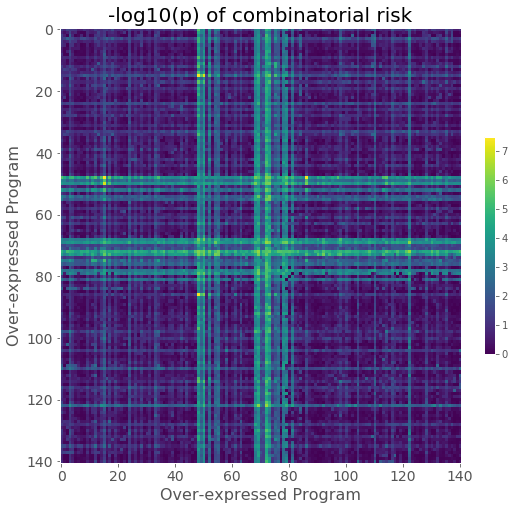

In [240]:
#Combination of over-expressed programs
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
subset_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
reference_matrix = overExpressedProgramsMatrix_pr.loc[:,subset_patients]
covariate_matrix = overExpressedProgramsMatrix_pr.loc[:,subset_patients]

pval_dfs = []
max_mean_dfs = []
for pr_ix in reference_matrix.index:
    if pr_ix%10==0:
        print("Performing iteration {:d} of {:d}".format(pr_ix+1,reference_matrix.shape[0]))
    tmp_pval = miner.combinatorial_risk(target,
                                  reference_matrix,
                                  covariate_matrix,
                                  primary_variable=pr_ix,
                                  min_group_size=5,
                                  sort=False)
    pval_dfs.append(tmp_pval.loc[:,"p-value"])
    max_mean_dfs.append(tmp_pval.loc[:,"highest_risk"])
    
#P-value combinatorial matrix
over_combinatorial_pvalues = pd.concat(pval_dfs,axis=1)
over_combinatorial_pvalues.columns = reference_matrix.index
over_combinatorial_pvalues.index = covariate_matrix.index

#Highest risk combination matrix
over_combinatorial_mean_risk = pd.concat(max_mean_dfs,axis=1)
over_combinatorial_mean_risk.columns = reference_matrix.index
over_combinatorial_mean_risk.index = covariate_matrix.index

#Transform data to -log10(p-values)
over_neglogp_combinatorial = -1*np.log10(over_combinatorial_pvalues)

#Plot the -log10(p-values) for the combinatorial risk
plt.figure(figsize=(8,8))
plt.imshow(over_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Over-expressed Program",fontsize=16)
plt.xlabel("Over-expressed Program",fontsize=16)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=20)
#plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_pvalues.pdf"),bbox_inches="tight")

Performing iteration 1 of 141
Performing iteration 11 of 141
Performing iteration 21 of 141
Performing iteration 31 of 141
Performing iteration 41 of 141
Performing iteration 51 of 141
Performing iteration 61 of 141
Performing iteration 71 of 141
Performing iteration 81 of 141
Performing iteration 91 of 141
Performing iteration 101 of 141
Performing iteration 111 of 141
Performing iteration 121 of 141
Performing iteration 131 of 141
Performing iteration 141 of 141


Text(0.5, 1.0, '-log10(p) of combinatorial risk')

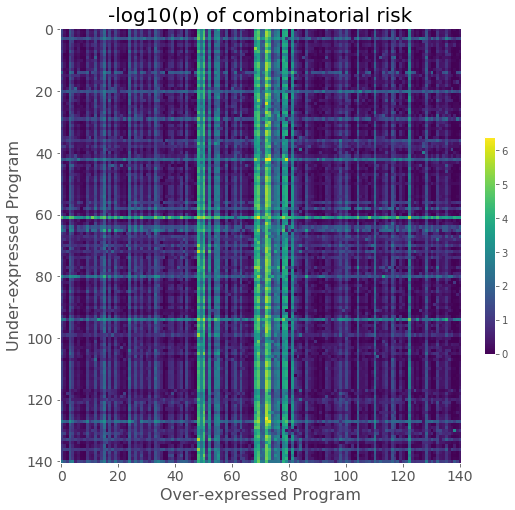

In [246]:
#Combination of over-expressed programs
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
subset_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
reference_matrix = overExpressedProgramsMatrix_pr.loc[:,subset_patients]
covariate_matrix = underExpressedProgramsMatrix_pr.loc[:,subset_patients]

pval_dfs = []
max_mean_dfs = []
for pr_ix in reference_matrix.index:
    if pr_ix%10==0:
        print("Performing iteration {:d} of {:d}".format(pr_ix+1,reference_matrix.shape[0]))
    tmp_pval = miner.combinatorial_risk(target,
                                  reference_matrix,
                                  covariate_matrix,
                                  primary_variable=pr_ix,
                                  min_group_size=5,
                                  sort=False)
    pval_dfs.append(tmp_pval.loc[:,"p-value"])
    max_mean_dfs.append(tmp_pval.loc[:,"highest_risk"])
    
#P-value combinatorial matrix
under_combinatorial_pvalues = pd.concat(pval_dfs,axis=1)
under_combinatorial_pvalues.columns = reference_matrix.index
under_combinatorial_pvalues.index = covariate_matrix.index

#Highest risk combination matrix
under_combinatorial_mean_risk = pd.concat(max_mean_dfs,axis=1)
under_combinatorial_mean_risk.columns = reference_matrix.index
under_combinatorial_mean_risk.index = covariate_matrix.index

#Transform data to -log10(p-values)
under_neglogp_combinatorial = -1*np.log10(under_combinatorial_pvalues)

#Plot the -log10(p-values) for the combinatorial risk
plt.figure(figsize=(8,8))
plt.imshow(under_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Under-expressed Program",fontsize=16)
plt.xlabel("Over-expressed Program",fontsize=16)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=20)
#plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_pvalues.pdf"),bbox_inches="tight")

Performing iteration 1 of 141
Performing iteration 11 of 141
Performing iteration 21 of 141
Performing iteration 31 of 141
Performing iteration 41 of 141
Performing iteration 51 of 141
Performing iteration 61 of 141
Performing iteration 71 of 141
Performing iteration 81 of 141
Performing iteration 91 of 141
Performing iteration 101 of 141
Performing iteration 111 of 141
Performing iteration 121 of 141
Performing iteration 131 of 141
Performing iteration 141 of 141


Text(0.5, 1.0, '-log10(p) of combinatorial risk')

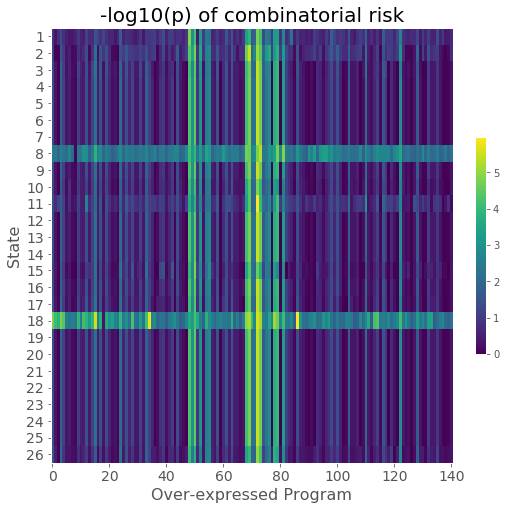

In [247]:
#Define Over-expressed programs versus states
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
subset_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
reference_matrix = overExpressedProgramsMatrix_pr.loc[:,subset_patients]
covariate_matrix = states_df.loc[:,subset_patients]

pval_dfs = []
max_mean_dfs = []
for pr_ix in reference_matrix.index:
    if pr_ix%10==0:
        print("Performing iteration {:d} of {:d}".format(pr_ix+1,reference_matrix.shape[0]))
    tmp_pval = miner.combinatorial_risk(target,
                                  reference_matrix,
                                  covariate_matrix,
                                  primary_variable=pr_ix,
                                  min_group_size=5,
                                  sort=False)
    pval_dfs.append(tmp_pval.loc[:,"p-value"])
    max_mean_dfs.append(tmp_pval.loc[:,"highest_risk"])
    
#P-value combinatorial matrix
states_combinatorial_pvalues = pd.concat(pval_dfs,axis=1)
states_combinatorial_pvalues.columns = reference_matrix.index
states_combinatorial_pvalues.index = covariate_matrix.index

#Highest risk combination matrix
states_combinatorial_mean_risk = pd.concat(max_mean_dfs,axis=1)
states_combinatorial_mean_risk.columns = reference_matrix.index
states_combinatorial_mean_risk.index = covariate_matrix.index

#Transform data to -log10(p-values)
states_neglogp_combinatorial = -1*np.log10(states_combinatorial_pvalues)

#Plot the -log10(p-values) for the combinatorial risk
plt.figure(figsize=(8,8))
plt.imshow(states_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(ticks=np.arange(states_df.shape[0]),
           labels=np.arange(1,states_df.shape[0]+1).astype(str),
           fontsize=14)
plt.ylabel("State",fontsize=16)
plt.xlabel("Over-expressed Program",fontsize=16)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=20)
#plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_pvalues.pdf"),bbox_inches="tight")

Performing iteration 1 of 141
Performing iteration 11 of 141
Performing iteration 21 of 141
Performing iteration 31 of 141
Performing iteration 41 of 141
Performing iteration 51 of 141
Performing iteration 61 of 141
Performing iteration 71 of 141
Performing iteration 81 of 141
Performing iteration 91 of 141
Performing iteration 101 of 141
Performing iteration 111 of 141
Performing iteration 121 of 141
Performing iteration 131 of 141
Performing iteration 141 of 141


Text(0.5, 1.0, '-log10(p) of combinatorial risk')

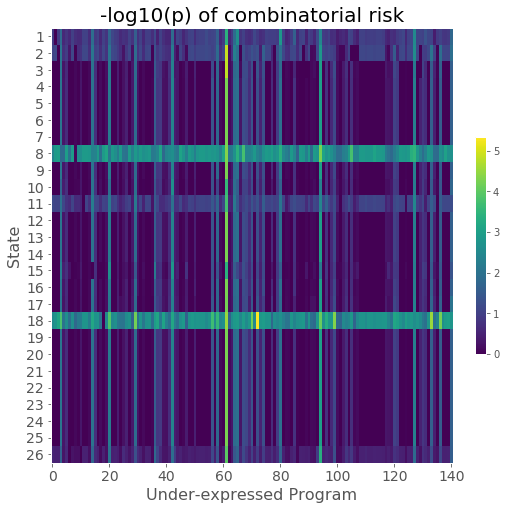

In [250]:
reload(miner)
#Define Over-expressed programs versus states
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
subset_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
reference_matrix = underExpressedProgramsMatrix_pr.loc[:,subset_patients]
covariate_matrix = states_df.loc[:,subset_patients]

pval_dfs = []
max_mean_dfs = []
for pr_ix in reference_matrix.index:
    if pr_ix%10==0:
        print("Performing iteration {:d} of {:d}".format(pr_ix+1,reference_matrix.shape[0]))
    tmp_pval = miner.combinatorial_risk(target,
                                  reference_matrix,
                                  covariate_matrix,
                                  primary_variable=pr_ix,
                                  min_group_size=5,
                                  sort=False)
    pval_dfs.append(tmp_pval.loc[:,"p-value"])
    max_mean_dfs.append(tmp_pval.loc[:,"highest_risk"])
    
#P-value combinatorial matrix
under_states_combinatorial_pvalues = pd.concat(pval_dfs,axis=1)
under_states_combinatorial_pvalues.columns = reference_matrix.index
under_states_combinatorial_pvalues.index = covariate_matrix.index

#Highest risk combination matrix
under_states_combinatorial_mean_risk = pd.concat(max_mean_dfs,axis=1)
under_states_combinatorial_mean_risk.columns = reference_matrix.index
under_states_combinatorial_mean_risk.index = covariate_matrix.index

#Transform data to -log10(p-values)
under_states_neglogp_combinatorial = -1*np.log10(under_states_combinatorial_pvalues)

#Plot the -log10(p-values) for the combinatorial risk
plt.figure(figsize=(8,8))
plt.imshow(under_states_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(ticks=np.arange(states_df.shape[0]),
           labels=np.arange(1,states_df.shape[0]+1).astype(str),
           fontsize=14)
plt.ylabel("State",fontsize=16)
plt.xlabel("Under-expressed Program",fontsize=16)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=20)
#plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_pvalues.pdf"),bbox_inches="tight")

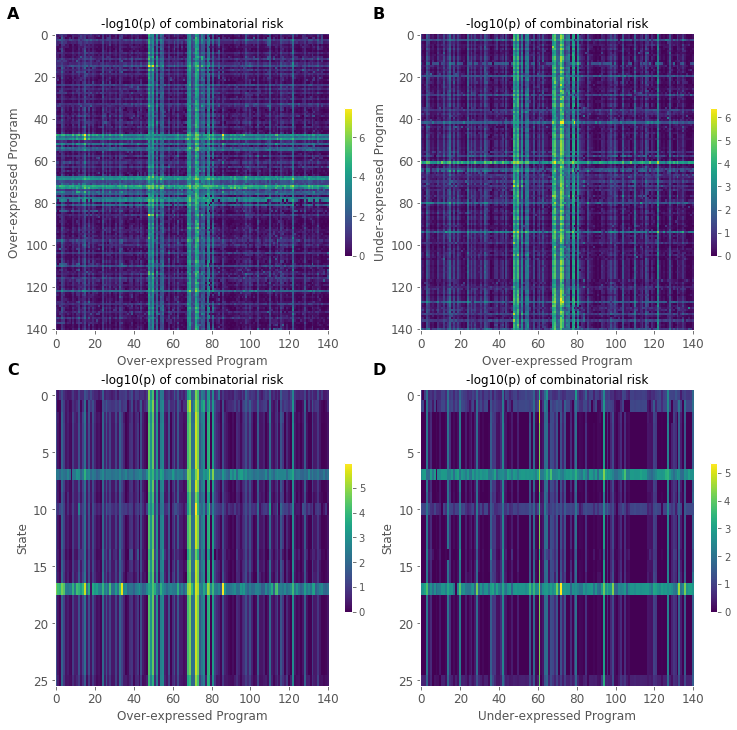

In [261]:
#Summary figure
fig, axs = plt.subplots(2,2)
fig.set_figheight(12)
fig.set_figwidth(12)

#programs over-over
plt.sca(axs[0,0])
plt.imshow(over_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Over-expressed Program",fontsize=12)
plt.xlabel("Over-expressed Program",fontsize=12)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=12)

#programs under-over
plt.sca(axs[0,1])
plt.imshow(under_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Under-expressed Program",fontsize=12)
plt.xlabel("Over-expressed Program",fontsize=12)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=12)

#programs over-states
plt.sca(axs[1,0])
plt.imshow(states_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("State",fontsize=12)
plt.xlabel("Over-expressed Program",fontsize=12)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=12)

#programs under-states
plt.sca(axs[1,1])
plt.imshow(under_states_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("State",fontsize=12)
plt.xlabel("Under-expressed Program",fontsize=12)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=12)

#Add letters
import string
axs = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]
for n, ax in enumerate(axs):  
    ax.text(-0.175, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_figure.pdf"),bbox_inches="tight")


In [965]:
min_vals = np.amin(combinatorial_pvalues)
opt_pr1 = np.argmin(min_vals)
opt_pr2 = np.argmin(combinatorial_pvalues.loc[:,opt_pr1])
print("The minimum p-value of {:.3e} occurs for program {:d} split by program {:d}".format(min(min_vals)
                                                                                           ,opt_pr1,
                                                                                           opt_pr2))

The minimum p-value of 1.920e-08 occurs for program 122 split by program 61


In [966]:
max_vals = np.amax(combinatorial_mean_risk)
opt_pr1 = np.argmax(max_vals)
opt_pr2 = np.argmax(combinatorial_mean_risk.loc[:,opt_pr1])
print("The maximum mean risk occurs for program {:d} split by program {:d}".format(opt_pr1,opt_pr2))


The maximum mean risk occurs for program 73 split by program 30


In [975]:
#Determine primary variable type
primary_variable = 122
covariate_variable = 61

indicator = len(set(reference_matrix.loc[primary_variable,:]))
if indicator == 2:
    primary_type = "binary"
elif indicator >2:
    primary_type = "categorical"

#Get target variable names outside of loop to save time
target_index = target.index

#Instantiate output lists
kw_stat_list = []
kw_p_list = []
index_list = []
labels = []

phenotypes = []
#Split population according to primary variable
if primary_type == "binary":
    phenotypes.append(miner.getMutations(primary_variable,reference_matrix))
    phenotypes.append(miner.setdiff(reference_matrix.columns,phenotype1))

if primary_type == "categorical":
    for cat in list(set(reference_matrix.loc[primary_variable,:])):
        phenotypes.append(reference_matrix.columns[
            np.where(reference_matrix.loc[primary_variable,:]==cat)[0]])

if primary_type == "continuous":
    phenotypes.append(reference_matrix.columns)

#Split population into subtypes based upon primary and categorical variables
for covariate in [covariate_variable]:
    interaction_subtypes = []
    cats = list(set(covariate_matrix.loc[covariate,:]))
    for cat in cats:
        subtype = covariate_matrix.columns[
            np.where(covariate_matrix.loc[covariate,:]==cat)[0]]
        for p in range(len(phenotypes)):
            phenotype = phenotypes[p]
            labels.append((" ").join([str(len(phenotypes)-1-p),str(cat)]))
            cat_subtype = miner.intersect(phenotype,subtype)
            interaction_subtypes.append(cat_subtype)
            
            
#kruskal-wallis of subtypes
kw_subtypes = []
lenkw = 0
for group in interaction_subtypes:
    kw_subtype = miner.intersect(target_index,group)
    if len(kw_subtype) >= min_group_size:
        kw_subtypes.append(target[kw_subtype])
        lenkw+=1
if lenkw >= 2:
    kw_stat, kw_p = stats.kruskal(*kw_subtypes)
    print(kw_p)
    
means = [np.mean(i) for i in kw_subtypes if len(miner.intersect(i.index,target_index))>=5]
max_mean = max(means)
print(max_mean)

print(labels)

1.9204566076614914e-08
0.8588011137711781
['1 0.0', '0 0.0', '1 1.0', '0 1.0']


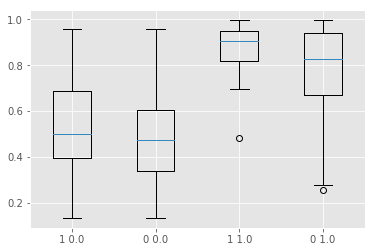

In [976]:
risk_subtypes = []
for subtype in interaction_subtypes:
    subtype = miner.intersect(subtype,guanSurvivalDfMMRF.index)
    risk_subtypes.append(guanSurvivalDfMMRF.loc[subtype,"GuanScore"])

_=plt.boxplot(risk_subtypes,labels=labels) 

In [977]:
ref_call = reference_matrix.columns[np.where(reference_matrix.loc[primary_variable,:]==1)[0]]
cov_call = covariate_matrix.columns[np.where(covariate_matrix.loc[covariate_variable,:]==1)[0]]
srv_call = guanSurvivalDfMMRF.index

highest_risk_subtype = miner.intersect(miner.intersect(ref_call,cov_call),srv_call)
print(len(miner.intersect(ref_call,cov_call)))
print(len(highest_risk_subtype))
np.mean(guanSurvivalDfMMRF.loc[highest_risk_subtype,:])

20
13


duration      240.000000
observed        0.923077
kmEstimate      0.894387
GuanScore       0.858801
dtype: float64

In [880]:
miner.intersect(states[14],miner.getMutations("RNASeq_WHSC1_Call",translocations))

['MMRF_2272_1_BM',
 'MMRF_1518_3_BM',
 'MMRF_1587_2_BM',
 'MMRF_1518_2_BM',
 'MMRF_2722_1_BM']

In [875]:
pr61_down = reference_matrix.columns[np.where(reference_matrix.loc[primary_variable,:]==1)[0]]
pr77_up = covariate_matrix.columns[np.where(covariate_matrix.loc[covariate_variable,:]==1)[0]]

tmp_comb = miner.intersect(pr61_down,pr77_up)
tmp_subtype = miner.intersect(tmp_comb,miner.getMutations("RNASeq_WHSC1_Call",translocations))
guanSurvivalDfMMRF.loc[miner.intersect(tmp_subtype,guanSurvivalDfMMRF.index),"GuanScore"]

MMRF_2272_1_BM    0.990741
Name: GuanScore, dtype: float64

In [ ]:
#73 down and 11 up VS 73 up and 11 neutral
#11 checks 73

#61 down and 77 neutral (no 77 up) vs 61 up and 77 down
#61 checks 77

## Compare program status to various features

In [ ]:
#Available tests:
#chisquare_binary_df - test and reference dfs are both binary
#wilcox_binary_df - test df is binary, reference df is continuous
#wilcox_df - continuous df with 2 phenotypes to compare
#decision_tree_predictor - test and reference features are both continuous

## Predict state using continuous programs

In [61]:
t414_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
t414_srv = miner.subset_survival(t414_patients,guanSurvivalDfMMRF)
t414_hr = list(t414_srv.index[0:int(round(0.35*t414_srv.shape[0]))])
subset_patients = t414_srv.index

target_df = pd.DataFrame(np.zeros((len(subset_patients),1)))
target_df.index = subset_patients
target_df.columns = ["HR_t414"]
target_df.loc[t414_hr,"HR_t414"] = 1

#subset_patients = expressionData.columns

Chi-square statistic: 0.68, p-value: 4.097e-01
col_0   0   1
row_0        
0      18  12
1       3   4


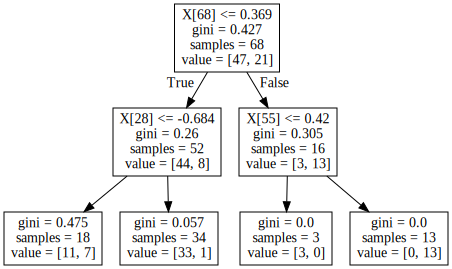

In [62]:
#Identify optimal combination of continuous features
clf, X_train, X_test, y_train, y_test, y_train_samples, y_test_samples = miner.decision_tree_predictor(
    ref_df=eigengenes_pr.loc[:,subset_patients],
    target=target_df,
    test_proportion=0.35,
    rs=12,
    depth=2,
    criterion="gini")

#Predict target class
tmp_train_predictions = clf.predict(X_train)
tmp_test_predictions = clf.predict(X_test)
 
#Print test performance
if len(set(tmp_test_predictions))>1:
    if len(set(y_test))>1:
        chi2, p, obs = miner.chi_square(tmp_test_predictions,y_test,table=True)
        print('Chi-square statistic: {:.2f}, p-value: {:.3e}'.format(chi2,p))
        print(obs)
        
#Visualize tree
miner.visualize_decision_tree(clf,filename=None)

## Predict state using discrete program activity

In [1135]:
reload(miner)
bin_df = common_mutations
ref_df = overExpressedProgramsMatrix_pr
pr_key = 68

chisq_results = miner.chisquare_binary_df(bin_df,ref_df,pr_key)
chisq_results.head()

,statistic,p-value
TP53,37.185968,1.073837e-09
ZNF462,12.174404,4.844978e-04
ZNF208,11.982900,5.369096e-04
CMYA5,11.915528,5.566795e-04
TTN,9.541820,2.008425e-03


In [ ]:
bin_df = common_mutations
ref_df = overExpressedProgramsMatrix_pr
pr_key = 68
chisq_results = chisquare_binary_df(bin_df,ref_df,pr_key)

In [1123]:
chisq_results = chisquare_binary_df(bin_df=states_df,ref_df=overExpressedProgramsMatrix_pr,pr_key=68)
chisq_results.head()

,statistic,p-value
15,45.987691,1.189983e-11
21,44.896723,2.077052e-11
1,20.219705,6.903811e-06
13,12.190397,4.803617e-04
4,10.043275,1.529051e-03


In [1124]:
chisq_results = chisquare_binary_df(bin_df=translocations,ref_df=overExpressedProgramsMatrix_pr,pr_key=68)
chisq_results.head()

,statistic,p-value
RNASeq_MYC_Call,7.989413,0.004705
RNASeq_MAF_Call,5.266072,0.021745
RNASeq_MAFA_Call,3.279238,0.070162
RNASeq_CCND3_Call,2.336438,0.126378
RNASeq_MAFB_Call,1.615868,0.203669


In [1133]:
reload(miner)

wilcox_results = miner.wilcox_binary_df(bin_df=translocations,
                                  cont_df=eigengenes_pr,
                                  pr_key=73)
wilcox_results.head()

,statistic,p-value
RNASeq_MAF_Call,6.680626,2.379235e-11
RNASeq_MYC_Call,5.531441,3.176105e-08
RNASeq_MAFA_Call,4.416430,1.003444e-05
RNASeq_MAFB_Call,3.780609,1.564449e-04
RNASeq_CCND2_Call,-0.550861,5.817287e-01


In [1127]:
wilcox_results = wilcox_binary_df(translocations,cont_df,pr_key=68)
wilcox_results

,statistic,p-value
RNASeq_MAF_Call,3.862306,0.000112
RNASeq_MYC_Call,3.753700,0.000174
RNASeq_MAFA_Call,2.300025,0.021447
RNASeq_CCND1_Call,1.614870,0.106339
RNASeq_CCND3_Call,1.540876,0.123347
RNASeq_CCND2_Call,1.454656,0.145765
RNASeq_WHSC1_Call,0.901528,0.367308
RNASeq_MAFB_Call,0.872955,0.382688
RNASeq_FGFR3_Call,0.354563,0.722917


In [1126]:
wilcox_results = wilcox_binary_df(states_df,cont_df,pr_key=1)
wilcox_results

,statistic,p-value
1,14.612533,2.336649e-48
2,8.773725,1.728516e-18
3,4.428992,9.467444e-06
16,4.299013,1.715607e-05
15,2.753081,5.903731e-03
10,2.581418,9.839549e-03
22,1.753247,7.955962e-02
9,1.045213,2.959245e-01
26,-0.003072,9.975486e-01
11,-0.251214,8.016489e-01


In [ ]:
program_ix = 68
mean_eigengene = []
mean_activity = []
wilcoxon_eigengene = []
wilcoxon_activity = []
guanrisk_mean = []


for s in range(len(states)):
    phenotype1 = states[s]
    phenotype2 = miner.setdiff(np.hstack(states),phenotype1)
    tmp_activity = np.mean(dfr_pr.loc[program_ix,phenotype1])
    tmp_eigengene = np.mean(eigengenes_pr.loc[program_ix,phenotype1])
    tmp_wilcox_activity = stats.ranksums(dfr_pr.loc[program_ix,phenotype1],dfr_pr.loc[program_ix,phenotype2])
    tmp_wilcox_eigengene = stats.ranksums(eigengenes_pr.loc[program_ix,phenotype1],eigengenes_pr.loc[program_ix,phenotype2])
    tmp_pats = miner.intersect(phenotype1,guanSurvivalDfMMRF.index)
    tmp_guan = 0
    if len(tmp_pats) >= 3:
        tmp_guan = guanSurvivalDfMMRF.loc[tmp_pats,"GuanScore"].mean()
         
    # Append to lists
    mean_eigengene.append(tmp_eigengene)
    mean_activity.append(tmp_activity)
    wilcoxon_eigengene.append(tmp_wilcox_eigengene)
    wilcoxon_activity.append(tmp_wilcox_activity)
    guanrisk_mean.append(tmp_guan)
    

## Investigate specific states

In [158]:
state_ix = 10

mean_eigengene = []
mean_activity = []
wilcoxon_eigengene = []
wilcoxon_activity = []

for program_ix in dfr_pr.index:

    phenotype1 = states[state_ix]
    phenotype2 = miner.setdiff(np.hstack(states),phenotype1)
    tmp_activity = np.mean(dfr_pr.loc[program_ix,phenotype1])
    tmp_eigengene = np.mean(eigengenes_pr.loc[program_ix,phenotype1])
    tmp_wilcox_activity = stats.ranksums(dfr_pr.loc[program_ix,phenotype1],dfr_pr.loc[program_ix,phenotype2])
    tmp_wilcox_eigengene = stats.ranksums(eigengenes_pr.loc[program_ix,phenotype1],eigengenes_pr.loc[program_ix,phenotype2])
    # Append to lists
    mean_eigengene.append(tmp_eigengene)
    mean_activity.append(tmp_activity)
    wilcoxon_eigengene.append(tmp_wilcox_eigengene)
    wilcoxon_activity.append(tmp_wilcox_activity)


<BarContainer object of 141 artists>

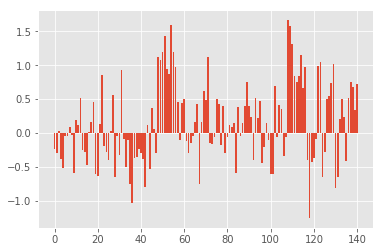

In [159]:
plt.bar(np.arange(len(mean_eigengene)),mean_eigengene)

## Gene set enrichment analysis

In [9]:
import gseapy as gp
from gseapy.plot import gseaplot

In [10]:
translocations.head()

,MMRF_1439_1_BM,MMRF_2778_1_BM,MMRF_2795_1_BM,MMRF_1137_3_BM,MMRF_1949_1_BM,MMRF_2384_1_BM,MMRF_1108_1_BM,MMRF_1988_1_BM,MMRF_1364_1_BM,MMRF_2554_1_BM,...,MMRF_1031_1_BM,MMRF_2194_1_BM,MMRF_2173_1_BM,MMRF_2352_1_BM,MMRF_2013_1_BM,MMRF_1766_1_BM,MMRF_1998_1_BM,MMRF_1462_3_BM,MMRF_1331_1_BM,MMRF_2613_1_BM
RNASeq_CCND1_Call,1,0,0,1,0,1,0,0,0,0,...,0,1,1,1,0,0,1,0,0,0
RNASeq_CCND2_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_CCND3_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_FGFR3_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNASeq_MAFA_Call,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [295]:
t1114_patients = miner.getMutations("RNASeq_CCND1_Call",translocations)
t1114_srv = subset_survival(t1114_patients,guanSurvivalDfMMRF)

#split into high and low-risk
risk_threshold = 0.7
high_risk_phenotype = t1114_srv.index[round(t1114_srv.loc[:,"GuanScore"],1)>=risk_threshold]
low_risk_phenotype = t1114_srv.index[round(t1114_srv.loc[:,"GuanScore"],1)<risk_threshold]
print("{:d} high-risk and {:d} low-risk patients".format(len(high_risk_phenotype),len(low_risk_phenotype)))

49 high-risk and 104 low-risk patients


In [303]:
#split into high and low-risk
risk_threshold = 0.7
high_risk_phenotype = guanSurvivalDfMMRF.index[round(guanSurvivalDfMMRF.loc[:,"GuanScore"],1)>=risk_threshold]
low_risk_phenotype = guanSurvivalDfMMRF.index[round(guanSurvivalDfMMRF.loc[:,"GuanScore"],1)<risk_threshold]
print("{:d} high-risk and {:d} low-risk patients".format(len(high_risk_phenotype),len(low_risk_phenotype)))

224 high-risk and 545 low-risk patients


In [285]:
#Generate ranked survival data for patient subset
t414_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
t414_srv = subset_survival(t414_patients,guanSurvivalDfMMRF)


#split into high and low-risk
risk_threshold = 0.7
high_risk_phenotype = t414_srv.index[round(t414_srv.loc[:,"GuanScore"],1)>=risk_threshold]
low_risk_phenotype = t414_srv.index[round(t414_srv.loc[:,"GuanScore"],1)<risk_threshold]

In [333]:
#'ARCHS4_Kinases_Coexp', ANKK1, AURKA, AURKB, BUB1, BUB1B
#Define phenotypes for differential expression ranking
mut_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
state_ix = 17
phenotype1 =  states[state_ix]
phenotype2 = miner.setdiff(mut_patients,phenotype1)

#Use Wilcoxon rank-sums to rank differential expression between phenotypes
wilcox_stats_w = []
wilcox_stats_p = []
for i in expressionData.index:
    tmp_wilcox = stats.ranksums(expressionData.loc[i,phenotype1],expressionData.loc[i,phenotype2])
    wilcox_stats_w.append(tmp_wilcox[0])
    wilcox_stats_p.append(tmp_wilcox[1])

# Produce formatted output for GSEA
rnk_st_21 = pd.DataFrame(wilcox_stats_w)
rnk_st_21.index = expressionData.index
rnk_st_21.sort_values(by=0,ascending=False,inplace=True)
rnk_st_21_hgnc = miner.gene_conversion(rnk_st_21.index,id_table = id_table,list_symbols=True)
rnk_st_21.index = rnk_st_21_hgnc
rnk_st_21.head()

,0
SP140,6.396381
ZNF181,6.092893
ACBD4,6.040866
KCTD11,5.760501
ZNF792,5.688241


## Perform hallmark enrichment analysis on each state

In [378]:
import time
#start timer
t1 = time.time()
state_hallmarks_dfs = []
for i in range(len(states)):
    
    # Print status update
    t_tmp = time.time()
    elapsed = float(t_tmp-t1)/60
    print("performing iteration {:d} of {:d}".format(i+1,len(states)+1))
    print("time elapsed: {:.2f} minutes".format(elapsed))
    
    # Define two phenotypes for comparison    
    phenotype1 =  states[i]
    phenotype2 = miner.setdiff(expressionData.columns,phenotype1)

    #Use Wilcoxon rank-sums to rank differential expression between phenotypes
    wilcox_stats_w = []
    wilcox_stats_p = []
    for j in expressionData.index:
        tmp_wilcox = stats.ranksums(expressionData.loc[j,phenotype1],expressionData.loc[j,phenotype2])
        wilcox_stats_w.append(tmp_wilcox[0])
        wilcox_stats_p.append(tmp_wilcox[1])

    # Produce formatted output for GSEA
    rnk_st_21 = pd.DataFrame(np.vstack([wilcox_stats_w,wilcox_stats_p]).T)
    rnk_st_21.index = expressionData.index
    rnk_st_21.sort_values(by=0,ascending=False,inplace=True)
    rnk_st_21_hgnc = miner.gene_conversion(rnk_st_21.index,id_table = id_table,list_symbols=True)
    rnk_st_21.index = rnk_st_21_hgnc
    rnk_st_21.to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"diff_exp.csv"])))
    rnk_st_21.drop(1,axis=1,inplace=True)
    rnk_st_21.head()

    # note: multiprocessing may not work on windows; takes about 10s on MacBook Air
    gs_db = 'MSigDB_Hallmark_2020'
    savefile = ("_").join(["State",str(state_ix),gs_db])
    pre_res = gp.prerank(rnk=rnk_st_21, gene_sets=gs_db,
                         processes=20,
                         permutation_num=100, # reduce number to speed up testing
                         outdir=savefile, format='png', seed=6)
    gsea_results = pre_res.res2d

    #save output to files
    miner.write_pkl(pre_res,os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.pkl"])))
    gsea_results.to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])))
    
    #Append df to state_hallmarks_dfs
    state_hallmarks_dfs.append(gsea_results)
    
t_tmp = time.time()
elapsed = float(t_tmp-t1)/60
print('completed iterations in {:.2f} minutes'.format(elapsed))


performing iteration 1 of 27
time elapsed: 0.00 minutes
performing iteration 2 of 27
time elapsed: 0.64 minutes
performing iteration 3 of 27
time elapsed: 1.24 minutes
performing iteration 4 of 27
time elapsed: 1.92 minutes
performing iteration 5 of 27
time elapsed: 2.63 minutes
performing iteration 6 of 27
time elapsed: 3.26 minutes
performing iteration 7 of 27
time elapsed: 3.85 minutes
performing iteration 8 of 27
time elapsed: 4.44 minutes
performing iteration 9 of 27
time elapsed: 5.02 minutes
performing iteration 10 of 27
time elapsed: 5.61 minutes
performing iteration 11 of 27
time elapsed: 6.19 minutes
performing iteration 12 of 27
time elapsed: 6.78 minutes
performing iteration 13 of 27
time elapsed: 7.37 minutes
performing iteration 14 of 27
time elapsed: 7.95 minutes
performing iteration 15 of 27
time elapsed: 8.54 minutes
performing iteration 16 of 27
time elapsed: 9.13 minutes
performing iteration 17 of 27
time elapsed: 9.72 minutes
performing iteration 18 of 27
time elaps

## Format enrichments into dataframe and correlate to risk

In [ ]:
state_id = []
state_risk = []
nes_scores = []
for i in range(len(states)):
    matched_pats = miner.intersect(states[i],guanSurvivalDfMMRF.index)
    if len(matched_pats) < 5:
        continue
    risk = np.median(guanSurvivalDfMMRF.loc[matched_pats,"GuanScore"])
    state_id.append(i+1)
    state_risk.append(risk)
    
    gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])),index_col=0,header=0)
    gsea_results.sort_values(by="nes",ascending=False,inplace=True)
    if i == 0:
        hallmark_index = gsea_results.index
    
    nes_df = pd.DataFrame(gsea_results.loc[hallmark_index,"nes"])
    nes_df.columns = [str(i+1)]
    nes_scores.append(nes_df)
    
# Concatenate enrichments into dataframe
nes_df = pd.concat(nes_scores,axis=1)  

# Correlate enrichments to risk
state_risk_correlation = miner.pearson_array(np.array(nes_df),np.array(state_risk))

# List terms in order of increasing risk
nes_df.index[np.argsort(state_risk_correlation)]

# Scatterplot of highest-risk enrichment versus risk
plt.scatter(nes_df.loc[nes_df.index[-1],:],state_risk)

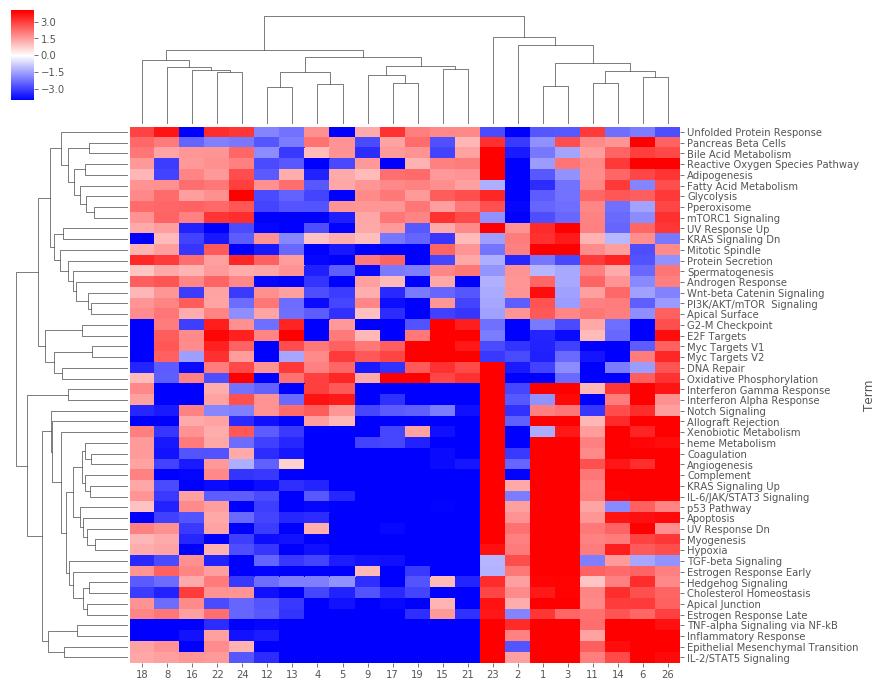

In [592]:
import seaborn as sns
g = sns.clustermap(nes_df.loc[:,:],figsize=(12,12),cmap="bwr",vmin=-4,vmax=4)
g
plt.savefig(os.path.join(resultsDirectory,"states_hallmarks_clustermap.pdf"),bbox_inches="tight")
#plt.imshow(nes_df.loc[t414_ordered_ix,t414_high_states],cmap="bwr",aspect="auto",vmin=-2,vmax=2)
#plt.grid(False)

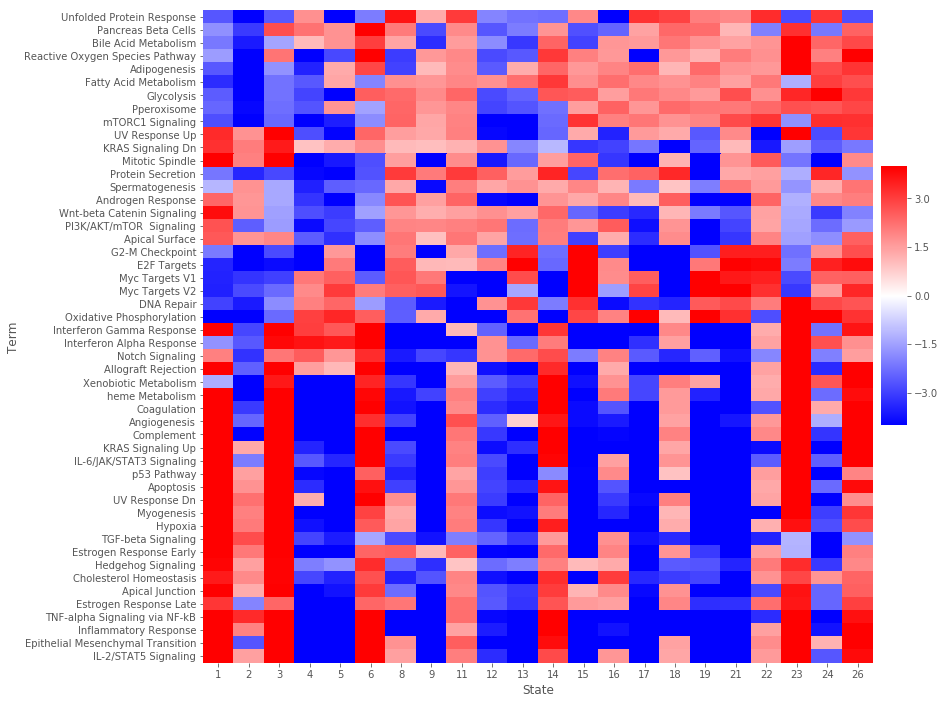

In [633]:
#Retrive hierarchical clustering ordering of hallmark enrichments
ordered_hallmarks = nes_df.index[g.dendrogram_row.reordered_ind]

#Plot heatmap with normal order of states
fig, ax = plt.subplots(1, 1)
fig.set_figheight(12)
fig.set_figwidth(12)
cbar_ax = fig.add_axes([.91, .4, .03, .3])
sns.heatmap(nes_df.loc[ordered_hallmarks,:],
            ax=ax, cbar_ax = cbar_ax, cbar=True,cmap="bwr",vmin=-4,vmax=4)
ax.set_xlabel("State")
plt.savefig(os.path.join(resultsDirectory,"states_hallmarks_heatmap_numeric.pdf"),bbox_inches="tight")

## Perform chip-seq enrichment analysis on each state

In [641]:
import time
#start timer
t1 = time.time()
state_chipseq_dfs = []
for i in range(len(states)):
    
    # Print status update
    t_tmp = time.time()
    elapsed = float(t_tmp-t1)/60
    print("performing iteration {:d} of {:d}".format(i+1,len(states)+1))
    print("time elapsed: {:.2f} minutes".format(elapsed))
    
    # Produce formatted output for GSEA
    rnk_st_21 = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"diff_exp.csv"])),index_col=0)
    rnk_st_21.columns = [0,1]
    rnk_st_21.drop(1,axis=1,inplace=True)

    # note: multiprocessing may not work on windows; takes about 10s on MacBook Air
    gs_db = 'ChEA_2016'
    savefile = ("_").join(["State",str(state_ix),gs_db])
    pre_res = gp.prerank(rnk=rnk_st_21, gene_sets=gs_db,
                         processes=20,
                         permutation_num=100, # reduce number to speed up testing
                         outdir=savefile, format='png', seed=6)
    gsea_results = pre_res.res2d

    #save output to files
    miner.write_pkl(pre_res,os.path.join(resultsDirectory,("_").join(["state",str(i),"chipseq","gsea.pkl"])))
    gsea_results.to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"chipseq","gsea.csv"])))
    
    #Append df to state_hallmarks_dfs
    state_chipseq_dfs.append(gsea_results)
    
t_tmp = time.time()
elapsed = float(t_tmp-t1)/60
print('completed iterations in {:.2f} minutes'.format(elapsed))


performing iteration 1 of 27
time elapsed: 0.00 minutes
performing iteration 2 of 27
time elapsed: 4.21 minutes
performing iteration 3 of 27
time elapsed: 8.28 minutes
performing iteration 4 of 27
time elapsed: 12.32 minutes
performing iteration 5 of 27
time elapsed: 16.30 minutes
performing iteration 6 of 27
time elapsed: 20.43 minutes
performing iteration 7 of 27
time elapsed: 24.45 minutes
performing iteration 8 of 27
time elapsed: 28.29 minutes
performing iteration 9 of 27
time elapsed: 32.22 minutes
performing iteration 10 of 27
time elapsed: 36.19 minutes
performing iteration 11 of 27
time elapsed: 40.15 minutes
performing iteration 12 of 27
time elapsed: 44.13 minutes
performing iteration 13 of 27
time elapsed: 48.18 minutes
performing iteration 14 of 27
time elapsed: 52.15 minutes
performing iteration 15 of 27
time elapsed: 56.06 minutes
performing iteration 16 of 27
time elapsed: 59.90 minutes
performing iteration 17 of 27
time elapsed: 63.99 minutes
performing iteration 18 of

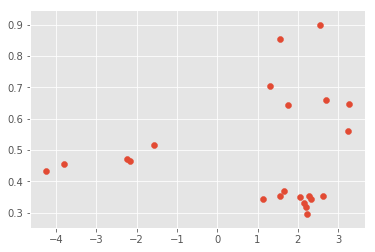

In [647]:
state_id = []
state_risk = []
nes_scores_chip = []
for i in range(len(states)):
    matched_pats = miner.intersect(states[i],guanSurvivalDfMMRF.index)
    if len(matched_pats) < 5:
        continue
    risk = np.median(guanSurvivalDfMMRF.loc[matched_pats,"GuanScore"])
    state_id.append(i+1)
    state_risk.append(risk)
    
    gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"chipseq","gsea.csv"])),index_col=0,header=0)
    gsea_results.sort_values(by="nes",ascending=False,inplace=True)
    if i == 0:
        hallmark_index = gsea_results.index
    
    nes_df_chip = pd.DataFrame(gsea_results.loc[hallmark_index,"nes"])
    nes_df_chip.columns = [str(i+1)]
    nes_scores_chip.append(nes_df_chip)
    
# Concatenate enrichments into dataframe
nes_df_chip = pd.concat(nes_scores_chip,axis=1)  

# Correlate enrichments to risk
state_risk_correlation = miner.pearson_array(np.array(nes_df_chip),np.array(state_risk))

# List terms in order of increasing risk
nes_df_chip.index[np.argsort(state_risk_correlation)]

# Scatterplot of highest-risk enrichment versus risk
plt.scatter(nes_df_chip.loc[nes_df_chip.index[-1],:],state_risk)

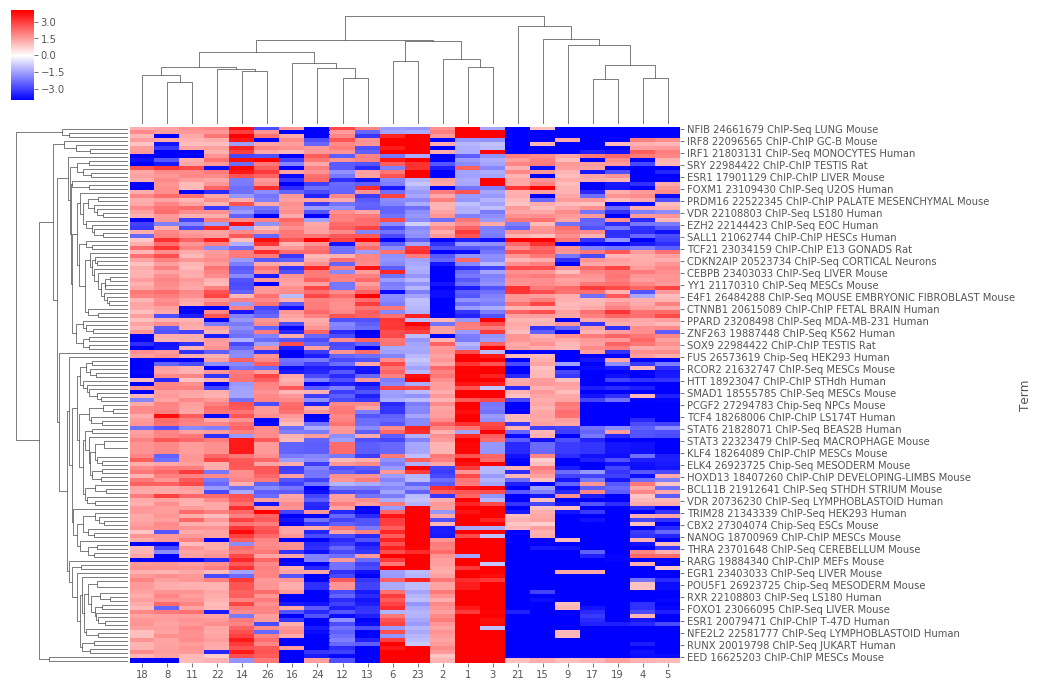

In [648]:
import seaborn as sns
g = sns.clustermap(nes_df_chip.loc[:,:],figsize=(12,12),cmap="bwr",vmin=-4,vmax=4)
g
plt.savefig(os.path.join(resultsDirectory,"states_chipseq_clustermap.pdf"),bbox_inches="tight")
#plt.imshow(nes_df.loc[t414_ordered_ix,t414_high_states],cmap="bwr",aspect="auto",vmin=-2,vmax=2)
#plt.grid(False)

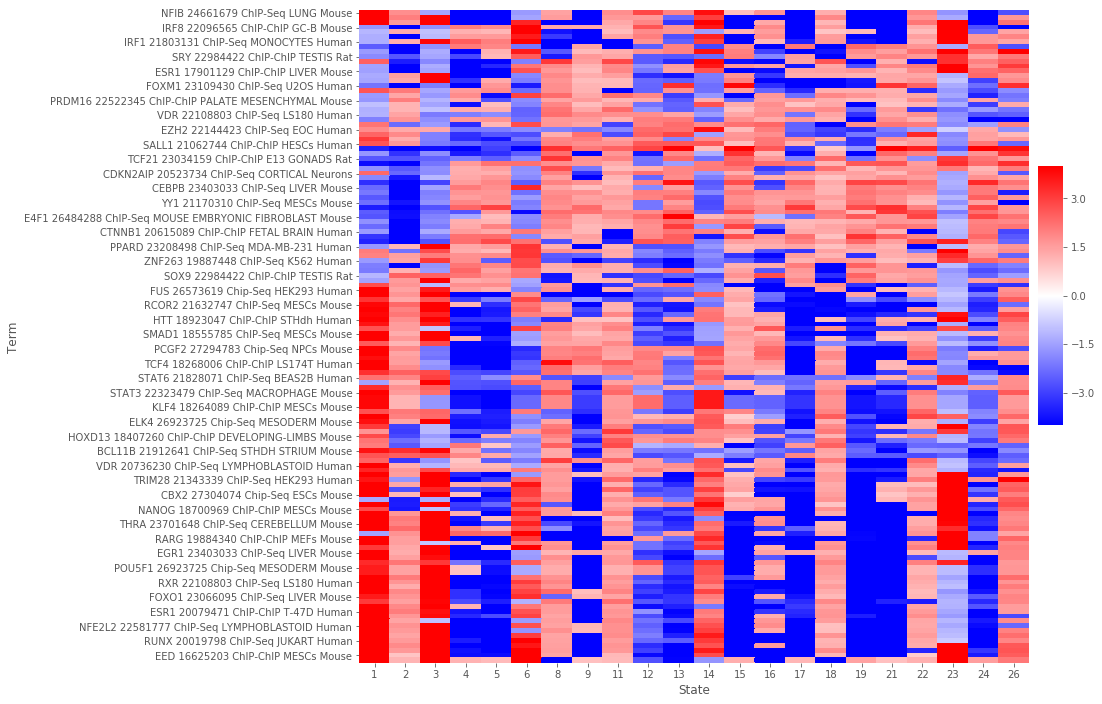

In [650]:
#Retrive hierarchical clustering ordering of hallmark enrichments
ordered_chip = nes_df_chip.index[g.dendrogram_row.reordered_ind]

#Plot heatmap with normal order of states
fig, ax = plt.subplots(1, 1)
fig.set_figheight(12)
fig.set_figwidth(12)
cbar_ax = fig.add_axes([.91, .4, .03, .3])
sns.heatmap(nes_df_chip.loc[ordered_chip,:],
            ax=ax, cbar_ax = cbar_ax, cbar=True,cmap="bwr",vmin=-4,vmax=4)
ax.set_xlabel("State")
plt.savefig(os.path.join(resultsDirectory,"states_chipseq_heatmap_numeric.pdf"),bbox_inches="tight")

## Perform pre-ranked GSEA

In [14]:
# Define two phenotypes for comparison    
phenotype1 =  states[14]
phenotype2 = miner.setdiff(expressionData.columns,phenotype1)

#Define the reference database
gs_db = 'Drug_Perturbations_from_GEO_down'

#Use Wilcoxon rank-sums to rank differential expression between phenotypes
wilcox_stats_w = []
wilcox_stats_p = []
for j in expressionData.index:
    tmp_wilcox = stats.ranksums(expressionData.loc[j,phenotype1],expressionData.loc[j,phenotype2])
    wilcox_stats_w.append(tmp_wilcox[0])
    wilcox_stats_p.append(tmp_wilcox[1])

# Produce formatted output for GSEA
rnk_st_21 = pd.DataFrame(np.vstack([wilcox_stats_w,wilcox_stats_p]).T)
rnk_st_21.index = expressionData.index
rnk_st_21.sort_values(by=0,ascending=False,inplace=True)
rnk_st_21_hgnc = miner.gene_conversion(rnk_st_21.index,id_table = id_table,list_symbols=True)
rnk_st_21.index = rnk_st_21_hgnc
#rnk_st_21.to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"diff_exp.csv"])))
rnk_st_21.drop(1,axis=1,inplace=True)
rnk_st_21.head()

# note: multiprocessing may not work on windows; takes about 10s on MacBook Air
savefile = ("_").join(["State",str(state_ix),gs_db])
pre_res = gp.prerank(rnk=rnk_st_21, gene_sets=gs_db,
                     processes=20,
                     permutation_num=100, # reduce number to speed up testing
                     outdir=savefile, format='png', seed=6)
gsea_results = pre_res.res2d

# View GSEA results
gsea_results.head(10)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
"2,2',4,4',5,5'-Hexachlorobiphenyl (PCB-153) 37034 human GSE6878 sample 3349",0.644660,4.330695,0.0,0.0,389,357,PLK1;MCM3;PA2G4;CCNA2;TUBB;GINS1;TUBA1C;TPX2;P...,PLK1;MCM3;PA2G4;CCNA2;TUBB;GINS1;TUBA1C;TPX2;P...
"2,2',4,4',5,5'-Hexachlorobiphenyl (PCB-153) 37034 human GSE6878 sample 3350",0.495414,3.200332,0.0,0.0,442,409,PLK1;PA2G4;CCNA2;TUBB;TPX2;TYMS;FAM72D;TOP2A;C...,PLK1;PA2G4;CCNA2;TUBB;TPX2;TYMS;FAM72D;TOP2A;C...
"2,2',4,4',5,5'-Hexachlorobiphenyl (PCB-153) 37034 human GSE6878 sample 3351",0.508678,3.210597,0.0,0.0,326,289,NUF2;CCNA2;GINS1;KIF4A;TPX2;PCNA;TYMS;TOP2A;AU...,NUF2;CCNA2;GINS1;KIF4A;TPX2;PCNA;TYMS;TOP2A;AU...
"2,3,7,8-tetrachlorodibenzo-p-dioxin 10852289 mouse GSE2812 sample 3600",0.486844,2.842954,0.0,0.0,262,228,CDC20;CDK1;SNRPE;PPIA;ADSL;EXOSC4;UQCC2;CCT4;G...,CDC20;CDK1;SNRPE;PPIA;ADSL;EXOSC4;UQCC2;CCT4;G...
"2,3,7,8-tetrachlorodibenzo-p-dioxin 10852289 mouse GSE2812 sample 3601",0.429733,2.808639,0.0,0.0,195,168,CCNA2;TUBA1C;CCNB1;TUBA1B;CDK1;RAN;RRM2;PPIA;R...,CCNA2;TUBA1C;CCNB1;TUBA1B;CDK1;RAN;RRM2;PPIA;R...
"3,3',4,4'-Tetrachlorobiphenyl 36187 human GSE6878 sample 3272",0.511984,3.108165,0.0,0.0,310,283,MCM3;TUBB;GINS1;TUBA1C;PCNA;TUBA1B;CCT3;ZWINT;...,MCM3;TUBB;GINS1;TUBA1C;PCNA;TUBA1B;CCT3;ZWINT;...
"3,3',4,4'-Tetrachlorobiphenyl 36187 human GSE6878 sample 3273",0.647920,4.115539,0.0,0.0,312,289,MCM4;PLK1;MCM3;PA2G4;CCNA2;TUBB;GINS1;TUBA1C;T...,MCM4;PLK1;MCM3;PA2G4;CCNA2;TUBB;GINS1;TUBA1C;T...
4-Hydroxynonenal 5283344 human GSE2397 sample 3078,0.534354,3.375521,0.0,0.0,356,329,PA2G4;CCNA2;TUBB;TPX2;PCNA;CCNB1;HDGF;UBE2C;AT...,PA2G4;CCNA2;TUBB;TPX2;PCNA;CCNB1;HDGF;UBE2C;AT...
4-Hydroxynonenal 5283344 human GSE2397 sample 3079,0.440551,2.854296,0.0,0.0,210,194,TUBB;TUBA1C;TPX2;ESPL1;TUBA1B;HDGF;RAN;SF3B4;K...,TUBB;TUBA1C;TPX2;ESPL1;TUBA1B;HDGF;RAN;SF3B4;K...


In [22]:
gsea_results.sort_values(by="nes",ascending=False,inplace=True)
gsea_results.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
vemurafenib DB08881 human GSE37441 sample 2561,0.780252,4.979490,0.0,0.0,335,306,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;PA2G4;KIF2C;...,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;PA2G4;KIF2C;...
PD173074 1401 human GSE52452 sample 2578,0.788369,4.888259,0.0,0.0,439,383,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;KIF2C;MCM10;...,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;KIF2C;MCM10;...
vemurafenib 42611257 human GSE42872 sample 2495,0.732791,4.658150,0.0,0.0,269,229,MCM4;TRIP13;NUF2;MCM3;MCM10;EXO1;CCNA2;GINS1;P...,MCM4;TRIP13;NUF2;MCM3;MCM10;EXO1;CCNA2;GINS1;P...
lapatinib DB01259 human GSE38376 sample 2586,0.708386,4.529970,0.0,0.0,291,276,TRIP13;TUBB;NEK2;CCNF;TUBA1C;TYMS;UBE2T;TOP2A;...,TRIP13;TUBB;NEK2;CCNF;TUBA1C;TYMS;UBE2T;TOP2A;...
vemurafenib DB08881 human GSE37441 sample 2564,0.737099,4.523934,0.0,0.0,358,332,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;PA2G4;KIF2C;...,MCM4;TRIP13;PLK1;NUF2;MCM3;DLGAP5;PA2G4;KIF2C;...


In [31]:
# to save your figure, make sure that ofname is not None
terms = pre_res.res2d.index
term_ix = 0

gseaplot(rank_metric=pre_res.ranking, term=terms[term_ix],figsize=(8,8),
         ofname=os.path.join(resultsDirectory,"perturbations_down_15.pdf"),
         **pre_res.results[terms[term_ix]])

In [29]:
import inspect
inspect.getsource(gseaplot)

'def gseaplot(rank_metric, term, hits_indices, nes, pval, fdr, RES,\n              pheno_pos=\'\', pheno_neg=\'\', figsize=(6,5.5), \n              cmap=\'seismic\', ofname=None, **kwargs):\n    """This is the main function for reproducing the gsea plot.\n\n    :param rank_metric: pd.Series for rankings, rank_metric.values.\n    :param term: gene_set name\n    :param hits_indices: hits indices of rank_metric.index presented in gene set S.\n    :param nes: Normalized enrichment scores.\n    :param pval: nominal p-value.\n    :param fdr: false discovery rate.\n    :param RES: running enrichment scores.\n    :param pheno_pos: phenotype label, positive correlated.\n    :param pheno_neg: phenotype label, negative correlated.\n    :param figsize: matplotlib figsize.\n    :param ofname: output file name. If None, don\'t save figure \n\n    """\n    # plt.style.use(\'classic\')\n    # center color map at midpoint = 0\n    norm = _MidpointNormalize(midpoint=0)\n\n    #dataFrame of ranked matrix

In [11]:
# note: multiprocessing may not work on windows; takes about 10s on MacBook Air
gs_db = 'Drug_Perturbations_from_GEO_down'
state_ix = 15
savefile = ("_").join(["State",str(state_ix),gs_db])
pre_res = gp.prerank(rnk=rnk_st_21, gene_sets=gs_db,
                     processes=20,
                     permutation_num=100, # reduce number to speed up testing
                     outdir=savefile, format='png', seed=6)
gsea_results = pre_res.res2d
# View GSEA results
gsea_results.head(10)

NameError: name 'rnk_st_21' is not defined

In [487]:
np.array(state_id)[np.argsort(state_risk)]-1

array([ 5,  4, 16, 23, 17, 13, 15, 18,  3,  8,  1,  0,  2, 11, 12, 22,  7,
       25, 20, 10, 21, 14])

In [504]:
i=17
gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])),index_col=0,header=0)
gsea_results.sort_values(by="nes",ascending=False,inplace=True)
upr_17 = gsea_results.loc["Unfolded Protein Response","ledge_genes"].split(";")
gsea_results

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Protein Secretion,0.535548,3.363175,0.000000,0.000000,96,92,RER1;GNAS;CLCN3;SEC24D;YIPF6;RAB9A;BNIP3;USO1;...,RER1;GNAS;CLCN3;SEC24D;YIPF6;RAB9A;BNIP3;USO1;...
Unfolded Protein Response,0.480953,2.944930,0.000000,0.010121,113,107,HERPUD1;SPCS1;SPCS3;WIPI1;PDIA6;HSP90B1;SRPRB;...,HERPUD1;SPCS1;SPCS3;WIPI1;PDIA6;HSP90B1;SRPRB;...
Androgen Response,0.382226,2.501016,0.000000,0.074220,100,94,UBE2J1;SPCS3;NKX3-1;AZGP1;SEC24D;STK39;RPS6KA3...,UBE2J1;SPCS3;NKX3-1;AZGP1;SEC24D;STK39;RPS6KA3...
Pancreas Beta Cells,0.462718,2.370107,0.015152,0.086028,40,25,NEUROG3;SPCS1;STXBP1;SRPRB;PAK3;MAFB;AKT3;ELP4...,NEUROG3;SPCS1;STXBP1;SRPRB;PAK3;MAFB;AKT3
Pperoxisome,0.347080,2.328211,0.000000,0.072870,104,99,SCP2;LONP2;ECI2;ABCB9;ABCD2;MVP;ACSL5;PEX2;EHH...,SCP2;LONP2;ECI2;ABCB9;ABCD2;MVP;ACSL5;PEX2;EHH...
Bile Acid Metabolism,0.319345,2.150398,0.015152,0.111330,112,97,NR3C2;SCP2;LONP2;SLC27A5;ABCD2;ACSL5;AR;PIPOX;...,NR3C2;SCP2;LONP2;SLC27A5;ABCD2;ACSL5;AR;PIPOX;...
Xenobiotic Metabolism,0.317009,2.024368,0.013158,0.190851,200,177,PINK1;AKR1C3;SLC35B1;CCL25;SLC35D1;ACSM1;ABCD2...,PINK1;AKR1C3;SLC35B1;CCL25;SLC35D1;ACSM1;ABCD2...
UV Response Dn,0.315189,1.992447,0.013333,0.188502,144,138,FZD2;SCN8A;CDC42BPA;ARHGEF9;CDON;CITED2;IGF1R;...,FZD2;SCN8A;CDC42BPA;ARHGEF9;CDON;CITED2;IGF1R;...
Complement,0.318728,1.960962,0.000000,0.191172,200,189,TIMP1;ANG;CTSO;ANXA5;IRF2;GNB4;CTSV;OLR1;WAS;S...,TIMP1;ANG;CTSO;ANXA5;IRF2;GNB4;CTSV;OLR1;WAS;S...


In [505]:
i=7
gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])),index_col=0,header=0)
gsea_results.sort_values(by="nes",ascending=False,inplace=True)
upr_7 = gsea_results.loc["Unfolded Protein Response","ledge_genes"].split(";")
gsea_results

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Unfolded Protein Response,0.417295,3.662462,0.000000,0.000000,113,107,SHC1;ATF6;ATF3;HSP90B1;YWHAZ;SPCS1;PDIA6;EDEM1...,SHC1;ATF6;ATF3;HSP90B1;YWHAZ;SPCS1;PDIA6;EDEM1...
Protein Secretion,0.401322,3.079545,0.000000,0.000000,96,92,ANP32E;SCAMP3;COG2;GNAS;ARF1;VPS45;ATP1A1;RPS6...,ANP32E;SCAMP3;COG2;GNAS;ARF1;VPS45;ATP1A1;RPS6...
Androgen Response,0.379724,2.666821,0.000000,0.031211,100,94,ADAMTS1;ELK4;AZGP1;RPS6KA3;STK39;LMAN1;GNAI3;A...,ADAMTS1;ELK4;AZGP1;RPS6KA3;STK39;LMAN1;GNAI3;A...
Myc Targets V1,0.333437,2.646560,0.000000,0.023408,200,195,ILF2;HNRNPU;CCT3;SRSF7;HNRNPR;MRPL9;ODC1;HDGF;...,ILF2;HNRNPU;CCT3;SRSF7;HNRNPR;MRPL9;ODC1;HDGF;...
E2F Targets,0.341153,2.550438,0.000000,0.032346,200,196,ANP32E;LBR;GINS3;CBX5;SMC1A;CKS1B;TMPO;LYAR;TU...,ANP32E;LBR;GINS3;CBX5;SMC1A;CKS1B;TMPO;LYAR;TU...
Myc Targets V2,0.393881,2.484478,0.030769,0.048235,58,58,TFB2M;PUS1;DDX18;NIP7;MRTO4;UTP20;NOP56;SRM;PH...,TFB2M;PUS1;DDX18;NIP7;MRTO4;UTP20;NOP56;SRM;PH...
Estrogen Response Early,0.323511,2.476054,0.000000,0.041344,200,183,KLF4;OPN3;IGF1R;ADCY1;ISG20L2;NRIP1;LRIG1;FARP...,KLF4;OPN3;IGF1R;ADCY1;ISG20L2;NRIP1;LRIG1;FARP...
mTORC1 Signaling,0.321455,2.435557,0.000000,0.042560,200,194,ALDOA;HSP90B1;CACYBP;UCHL5;PNP;EDEM1;ATP2A2;TU...,ALDOA;HSP90B1;CACYBP;UCHL5;PNP;EDEM1;ATP2A2;TU...
Pperoxisome,0.330452,2.381070,0.000000,0.046343,104,99,GNPAT;FDPS;LONP2;ABCB9;ALDH9A1;ABCD2;PABPC1;PE...,GNPAT;FDPS;LONP2;ABCB9;ALDH9A1;ABCD2;PABPC1;PE...


In [506]:
i=10
gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])),index_col=0,header=0)
gsea_results.sort_values(by="nes",ascending=False,inplace=True)
upr_10 = gsea_results.loc["Unfolded Protein Response","ledge_genes"].split(";")
gsea_results


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Unfolded Protein Response,0.458046,3.076153,0.000000,0.012065,113,107,SHC1;HERPUD1;WFS1;SLC1A4;ATF6;XBP1;PDIA6;HSP90...,SHC1;HERPUD1;WFS1;SLC1A4;ATF6;XBP1;PDIA6;HSP90...
Protein Secretion,0.474187,3.063944,0.000000,0.006033,96,92,LMAN1;SCAMP3;GNAS;USO1;VAMP4;ANP32E;TMED2;CLCN...,LMAN1;SCAMP3;GNAS;USO1;VAMP4;ANP32E;TMED2;CLCN...
Angiogenesis,0.418187,2.725008,0.018182,0.008043,36,32,TIMP1;S100A4;COL5A2;KCNJ8;FGFR1;JAG1;CCND2;APP...,TIMP1;S100A4;COL5A2;KCNJ8;FGFR1;JAG1;CCND2;APP...
Epithelial Mesenchymal Transition,0.378002,2.520394,0.000000,0.036195,200,186,LAMC1;GAS1;FBN2;GEM;NT5E;TIMP1;SDC1;SERPINE2;C...,LAMC1;GAS1;FBN2;GEM;NT5E;TIMP1;SDC1;SERPINE2;C...
Estrogen Response Early,0.394061,2.466274,0.000000,0.045847,200,183,KLF4;WFS1;SLC1A4;NRIP1;XBP1;MPPED2;FARP1;MYBL1...,KLF4;WFS1;SLC1A4;NRIP1;XBP1;MPPED2;FARP1;MYBL1...
Androgen Response,0.401832,2.433479,0.000000,0.044239,100,94,ADAMTS1;LMAN1;SEC24D;UAP1;RPS6KA3;GSR;PMEPA1;D...,ADAMTS1;LMAN1;SEC24D;UAP1;RPS6KA3;GSR;PMEPA1;D...
Glycolysis,0.383790,2.384910,0.000000,0.044813,200,191,HAX1;GFPT1;GOT1;CTH;PKP2;NT5E;SDC1;NOL3;COG2;A...,HAX1;GFPT1;GOT1;CTH;PKP2;NT5E;SDC1;NOL3;COG2;A...
TNF-alpha Signaling via NF-kB,0.380931,2.280985,0.000000,0.066358,200,192,KLF4;MCL1;GEM;CXCL2;TRIB1;SERPINB8;CXCL3;DUSP1...,KLF4;MCL1;GEM;CXCL2;TRIB1;SERPINB8;CXCL3;DUSP1...
Estrogen Response Late,0.371235,2.248914,0.000000,0.065688,200,180,KLF4;WFS1;SLC1A4;NRIP1;XBP1;FARP1;CA2;DNAJC12;...,KLF4;WFS1;SLC1A4;NRIP1;XBP1;FARP1;CA2;DNAJC12;...


In [507]:
i=21
gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])),index_col=0,header=0)
gsea_results.sort_values(by="nes",ascending=False,inplace=True)
upr_21 = gsea_results.loc["Unfolded Protein Response","ledge_genes"].split(";")
gsea_results


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
E2F Targets,0.575440,3.904008,0.000000,0.000000,200,196,MTHFD2;EXOSC8;CDK4;AK2;MCM6;TK1;MCM5;NBN;MCM3;...,MTHFD2;EXOSC8;CDK4;AK2;MCM6;TK1;MCM5;NBN;MCM3;...
G2-M Checkpoint,0.528294,3.528177,0.000000,0.000000,200,188,SLC7A1;SLC38A1;ATF5;RPS6KA5;CDK4;KMT5A;CCND1;M...,SLC7A1;SLC38A1;ATF5;RPS6KA5;CDK4;KMT5A;CCND1;M...
Myc Targets V1,0.456345,3.469062,0.000000,0.000000,200,195,XPOT;ERH;PCBP1;SNRPD3;CDK4;APEX1;PRPS2;MCM6;MC...,XPOT;ERH;PCBP1;SNRPD3;CDK4;APEX1;PRPS2;MCM6;MC...
Unfolded Protein Response,0.479325,3.305531,0.000000,0.002934,113,107,EIF4EBP1;PSAT1;XPOT;EDEM1;ASNS;MTHFD2;CHAC1;ST...,EIF4EBP1;PSAT1;XPOT;EDEM1;ASNS;MTHFD2;CHAC1;ST...
Myc Targets V2,0.462186,3.249842,0.000000,0.002347,58,58,NDUFAF4;CDK4;PES1;LAS1L;MCM5;MRTO4;PUS1;PLK4;H...,NDUFAF4;CDK4;PES1;LAS1L;MCM5;MRTO4;PUS1;PLK4;H...
mTORC1 Signaling,0.450729,3.171229,0.000000,0.001956,200,194,SHMT2;SLC7A11;VLDLR;PHGDH;PSAT1;SLC1A5;EDEM1;A...,SHMT2;SLC7A11;VLDLR;PHGDH;PSAT1;SLC1A5;EDEM1;A...
Mitotic Spindle,0.320576,2.577559,0.000000,0.036883,199,195,MID1IP1;ARHGAP10;RAB3GAP1;PXN;RHOF;CDC42EP1;FL...,MID1IP1;ARHGAP10;RAB3GAP1;PXN;RHOF;CDC42EP1;FL...
Androgen Response,0.298564,2.415935,0.109091,0.071881,100,94,STK39;PLPP1;CCND1;CAMKK2;ZMIZ1;SLC38A2;AKT1;CD...,STK39;PLPP1;CCND1;CAMKK2;ZMIZ1;SLC38A2;AKT1;CD...
Pperoxisome,0.316992,2.352958,0.052632,0.095189,104,99,ACSL5;ACSL1;PEX2;TSPO;SEMA3C;MSH2;IDH1;ABCB1;F...,ACSL5;ACSL1;PEX2;TSPO;SEMA3C;MSH2;IDH1;ABCB1;F...


In [508]:
i=13
gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])),index_col=0,header=0)
gsea_results.sort_values(by="nes",ascending=False,inplace=True)
upr_13 = gsea_results.loc["Unfolded Protein Response","ledge_genes"].split(";")
gsea_results

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Inflammatory Response,0.441227,5.744736,0.000000,0.000000,200,180,CD14;CMKLR1;AXL;MARCO;HRH1;PTAFR;IL18;SCN1B;GN...,CD14;CMKLR1;AXL;MARCO;HRH1;PTAFR;IL18;SCN1B;GN...
KRAS Signaling Up,0.380960,4.839094,0.000000,0.000000,200,177,F2RL1;CMKLR1;NRP1;IRF8;DUSP6;FCER1G;SCN1B;TMEM...,F2RL1;CMKLR1;NRP1;IRF8;DUSP6;FCER1G;SCN1B;TMEM...
Coagulation,0.410625,4.815927,0.000000,0.000000,138,116,CTSB;APOC1;C1QA;CFD;DUSP6;A2M;LGMN;LRP1;SERPIN...,CTSB;APOC1;C1QA;CFD;DUSP6;A2M;LGMN;LRP1;SERPIN...
heme Metabolism,0.416796,4.426499,0.000000,0.000000,200,187,CTSB;SELENBP1;LMO2;TNS1;LPIN2;FBXO9;SDCBP;BCAM...,CTSB;SELENBP1;LMO2;TNS1;LPIN2;FBXO9;SDCBP;BCAM...
Xenobiotic Metabolism,0.364742,4.285457,0.000000,0.003338,200,177,CD36;ABCC3;APOE;IRF8;HMOX1;CYP2S1;SLC46A3;TMEM...,CD36;ABCC3;APOE;IRF8;HMOX1;CYP2S1;SLC46A3;TMEM...
Complement,0.429660,4.261275,0.000000,0.002781,200,189,CD36;CTSB;APOC1;PLA2G7;CR1;C1QA;DUSP6;CTSD;LIP...,CD36;CTSB;APOC1;PLA2G7;CR1;C1QA;DUSP6;CTSD;LIP...
TNF-alpha Signaling via NF-kB,0.373140,4.058400,0.000000,0.002384,200,192,CCND1;F2RL1;CEBPD;IL18;CCL2;ETS2;FOSB;TLR2;DEN...,CCND1;F2RL1;CEBPD;IL18;CCL2;ETS2;FOSB;TLR2;DEN...
IL-6/JAK/STAT3 Signaling,0.462974,3.913477,0.000000,0.004172,87,83,CD36;CD14;HMOX1;A2M;PDGFC;EBI3;TLR2;TNFRSF1B;I...,CD36;CD14;HMOX1;A2M;PDGFC;EBI3;TLR2;TNFRSF1B;I...
Epithelial Mesenchymal Transition,0.351229,3.805291,0.000000,0.005563,200,186,VCAM1;TGFBI;LRP1;TGM2;CXCL12;CTHRC1;TIMP3;IGFB...,VCAM1;TGFBI;LRP1;TGM2;CXCL12;CTHRC1;TIMP3;IGFB...


In [ ]:
# For all states with at least min_state_pct patients of genotype1
# Record all significant up and down regulated hallmarks
# Produce intersection of these pathways for 

In [518]:
t414_high_states = np.array([8,26,11,15]).astype(str)
t414_low_states = np.array([1,18]).astype(str)
t1114_high_states = np.array([22,26,15]).astype(str)
t1114_low_states = np.array([24,14,2,1]).astype(str)

In [540]:
#Sort by pathway differences
diff_hits = nes_df.loc[:,t414_high_states].max(axis=1)-nes_df.loc[:,t414_high_states].min(axis=1)
t414_ordered_ix = nes_df.index[np.argsort(-diff_hits)]
nes_df.loc[t414_ordered_ix,t414_high_states]


,8,26,11,15
Term,,,,
Inflammatory Response,-5.056184,5.008651,1.467614,-12.065087
TNF-alpha Signaling via NF-kB,-6.448909,3.741959,2.280985,-9.641133
Myc Targets V1,2.646560,2.482931,-6.552612,4.598580
Complement,-4.181402,3.970443,2.152807,-7.123766
IL-6/JAK/STAT3 Signaling,-3.069666,4.917005,2.017079,-5.425107
IL-2/STAT5 Signaling,1.483183,3.817402,2.002065,-6.046788
KRAS Signaling Up,-2.816255,4.334703,1.965340,-5.384250
Interferon Gamma Response,-5.081449,3.677598,1.109654,-6.033513
heme Metabolism,-3.610052,3.810229,1.984967,-5.870396


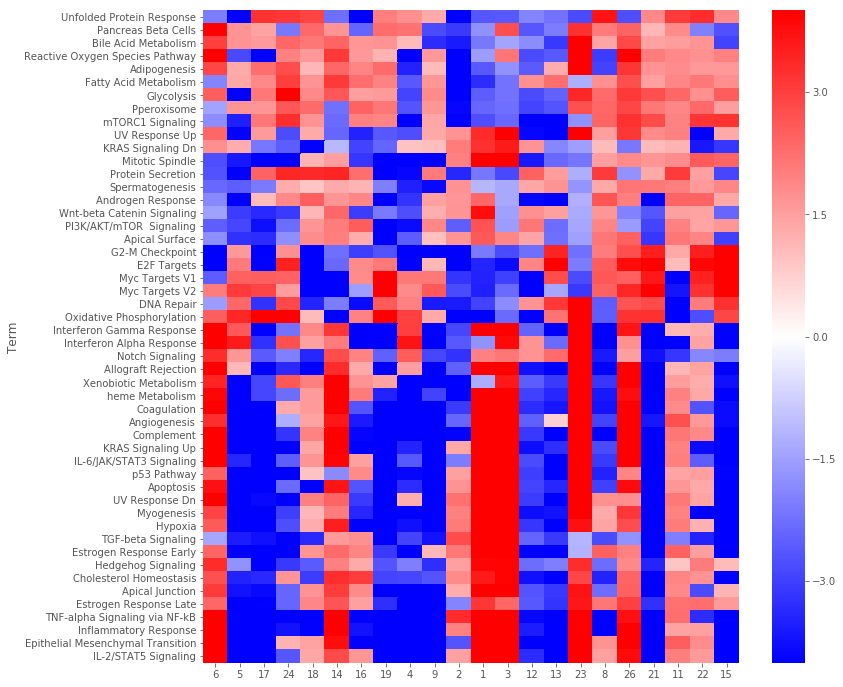

In [594]:
plt.figure(figsize=(12,12))
sns.heatmap(nes_df.loc[ordered_hallmarks,ordered_states],cmap="bwr",vmin=-4,vmax=4)
plt.savefig(os.path.join(resultsDirectory,"states_hallmarks_heatmap_risk.pdf"),bbox_inches="tight")

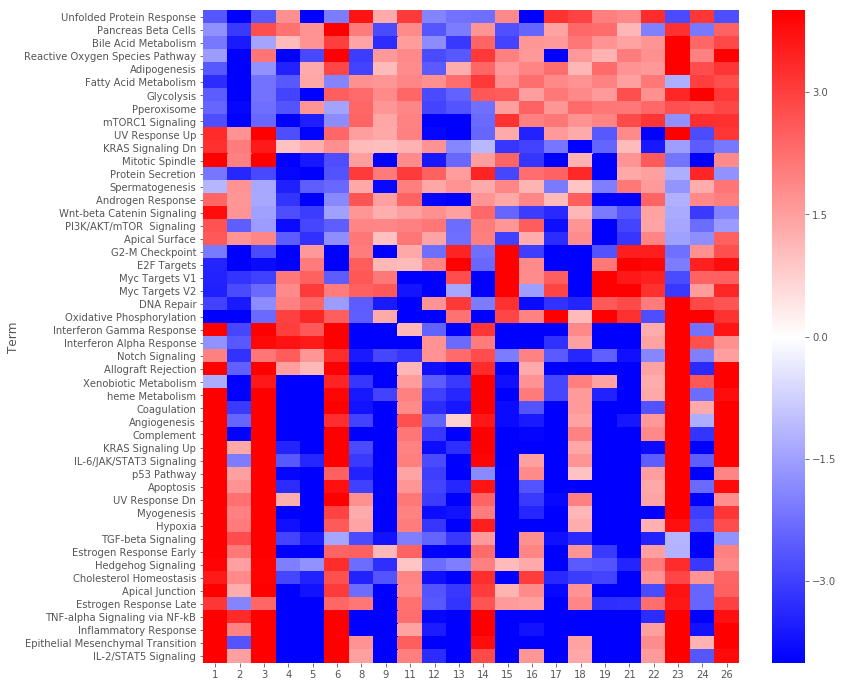

In [595]:
plt.figure(figsize=(12,12))
sns.heatmap(nes_df.loc[ordered_hallmarks,:],cmap="bwr",vmin=-4,vmax=4)
plt.savefig(os.path.join(resultsDirectory,"states_hallmarks_heatmap_numeric.pdf"),bbox_inches="tight")

In [517]:
# Define two phenotypes for comparison
phenotype1 = t414_high_states
phenotype2 = t414_low_states

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_state = miner.wilcox_df(nes_df,phenotype1,phenotype2)

# View top results
wilcoxon_state.head(10)

,Statistic,p-value
Term,,
KRAS Signaling Dn,1.732051,0.083265
mTORC1 Signaling,1.732051,0.083265
Apoptosis,1.732051,0.083265
Mitotic Spindle,1.732051,0.083265
Spermatogenesis,1.732051,0.083265
G2-M Checkpoint,1.732051,0.083265
Allograft Rejection,1.732051,0.083265
Glycolysis,1.732051,0.083265
Fatty Acid Metabolism,1.732051,0.083265


In [432]:
state_id = []
state_risk = []
nes_scores = []
for i in range(len(states)):
    matched_pats = miner.intersect(states[i],guanSurvivalDfMMRF.index)
    if len(matched_pats) < 5:
        continue
    risk = np.median(guanSurvivalDfMMRF.loc[matched_pats,"GuanScore"])
    state_id.append(i+1)
    state_risk.append(risk)
    
    gsea_results = pd.read_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"hallmarks","gsea.csv"])),index_col=0,header=0)
    gsea_results.sort_values(by="nes",ascending=False,inplace=True)
    if i == 0:
        hallmark_index = gsea_results.index
    
    nes_df = pd.DataFrame(gsea_results.loc[hallmark_index,"nes"])
    nes_df.columns = [str(i+1)]
    nes_scores.append(nes_df)
    
# Concatenate enrichments into dataframe
nes_df = pd.concat(nes_scores,axis=1)  

# Correlate enrichments to risk
state_risk_correlation = miner.pearson_array(np.array(nes_df),np.array(state_risk))

# List terms in order of increasing risk
nes_df.index[np.argsort(state_risk_correlation)]

# Scatterplot of highest-risk enrichment versus risk
plt.scatter(nes_df.loc[nes_df.index[-1],:],state_risk)

In [433]:
state_risk_correlation = miner.pearson_array(np.array(nes_df),np.array(state_risk))
nes_df.index[np.argsort(state_risk_correlation)]

Index(['Notch Signaling', 'Interferon Alpha Response', 'Pancreas Beta Cells',
       'TGF-beta Signaling', 'Oxidative Phosphorylation', 'KRAS Signaling Dn',
       'Bile Acid Metabolism', 'IL-6/JAK/STAT3 Signaling',
       'Interferon Gamma Response', 'Inflammatory Response', 'Myogenesis',
       'Xenobiotic Metabolism', 'Cholesterol Homeostasis',
       'TNF-alpha Signaling via NF-kB', 'heme Metabolism', 'KRAS Signaling Up',
       'IL-2/STAT5 Signaling', 'Coagulation', 'Allograft Rejection',
       'Estrogen Response Early', 'UV Response Dn', 'Adipogenesis',
       'Complement', 'p53 Pathway', 'Apical Junction', 'Protein Secretion',
       'Hypoxia', 'Apoptosis', 'Wnt-beta Catenin Signaling', 'Angiogenesis',
       'Epithelial Mesenchymal Transition', 'Apical Surface', 'UV Response Up',
       'Fatty Acid Metabolism', 'Reactive Oxygen Species Pathway',
       'Androgen Response', 'Myc Targets V1', 'Myc Targets V2',
       'Hedgehog Signaling', 'Glycolysis', 'Pperoxisome',
       'Unf

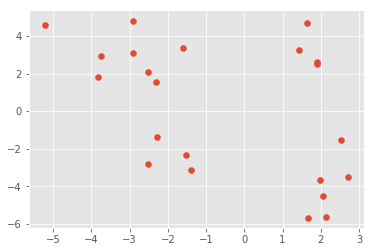

In [471]:
plt.scatter(nes_df.loc[nes_df.index[-1],:],state_risk)


In [472]:
bm_1 = nes_df.loc['Myc Targets V2',:]>2
bm_2 = np.array(state_risk)>0.6
bm_3 = np.array(state_risk)<=0.6

bm_4 = nes_df.loc['Myc Targets V1',:]>2
bm_5 = nes_df.loc['mTORC1 Signaling',:]>2
bm_6 = nes_df.loc['Unfolded Protein Response',:]>2
bm_7 = nes_df.loc['PI3K/AKT/mTOR  Signaling',:]>1
bm_8 = nes_df.loc['Hedgehog Signaling',:]>1
bm_9 = nes_df.loc['Wnt-beta Catenin Signaling',:]>1
bm_10 = nes_df.loc['IL-6/JAK/STAT3 Signaling',:]>1

high_risk_mycv2 = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[bm_2])
low_risk_mycv2 = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[~bm_2])


In [473]:
mycv2_pi3k = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[bm_7])
mycv2_shh = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[bm_8])
mycv2_wnt = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[bm_9])
mycv2_il6 = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[bm_10])

In [474]:
mycv1_mycv2 = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[bm_4])
mycv2_mtorc1 = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[bm_5])
mycv2_upr = miner.intersect(np.array(state_id)[bm_1],np.array(state_id)[bm_6])

In [475]:
print(mycv2_pi3k)
print(mycv2_shh)
print(mycv2_wnt)
print(mycv2_il6)

[8, 9, 22, 15]
[26, 22, 6, 15]
[8, 9, 22]
[26, 6]


In [456]:
np.array(state_id)[np.argsort(state_risk)]

array([ 6,  5, 17, 24, 18, 14, 16, 19,  4,  9,  2,  1,  3, 12, 13, 23,  8,
       26, 21, 11, 22, 15])

In [457]:
print(mycv1_mycv2)
print(mycv2_mtorc1)
print(mycv2_upr)
print(np.array(state_id)[bm_5])

[5, 8, 9, 15, 17, 19, 21, 22, 26]
[8, 15, 17, 21, 22, 26]
[8, 17, 19, 22]
[ 8 15 17 21 22 24 26]


In [424]:
# Define two phenotypes for comparison
phenotype1 = np.array(high_risk_mycv2).astype(str)
phenotype2 = np.array(low_risk_mycv2).astype(str)

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_state = miner.wilcox_df(nes_df,phenotype1,phenotype2)

# View top results
wilcoxon_state.head(10)

,Statistic,p-value
Term,,
mTORC1 Signaling,2.738613,0.006170
Mitotic Spindle,2.738613,0.006170
G2-M Checkpoint,2.738613,0.006170
Spermatogenesis,2.738613,0.006170
E2F Targets,2.738613,0.006170
Glycolysis,2.008316,0.044610
Myc Targets V1,2.008316,0.044610
Apical Surface,2.008316,0.044610
Unfolded Protein Response,1.825742,0.067889


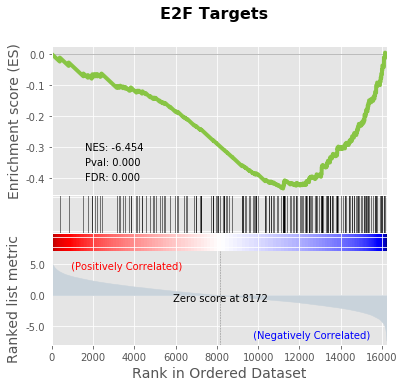

In [336]:
# to save your figure, make sure that ofname is not None
terms = pre_res.res2d.index
term_ix = 0
gseaplot(rank_metric=pre_res.ranking, term=terms[term_ix], **pre_res.results[terms[term_ix]])


In [211]:
# note: multiprocessing may not work on windows; takes about 10s on MacBook Air
gs_db = 'GO_Biological_Process_2018'
savefile = ("_").join(["State",str(state_ix),gs_db])
pre_res_gobp = gp.prerank(rnk=rnk_st_21, gene_sets=gs_db,
                     processes=7,
                     permutation_num=100, # reduce number to speed up testing
                     outdir=savefile, format='png', seed=6)
gsea_results_gobp = pre_res_gobp.res2d
# View GSEA results
gsea_results_gobp.head(10)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
gene expression (GO:0010467),-0.393105,-11.575404,0.0,0.000000,412,393,SWT1;NFE2;RRBP1;ALKBH5;RPS6KB2;NR4A2;SRSF7;TDR...,YARS2;MRPL32;ZBTB25;RPS14;DHX9;RPS27A;CELF2;MR...
rRNA processing (GO:0006364),-0.582867,-11.297232,0.0,0.000000,203,199,DIS3L;ISG20L2;PELP1;RPLP0;SRFBP1;RPL41;PES1;BY...,RRP7A;RPS3A;RPL18;SART1;RPS24;WDR46;SKIV2L2;RP...
translation (GO:0006412),-0.479625,-11.098282,0.0,0.000000,233,224,RRBP1;MARS;RPS6KB2;IARS2;TARS2;EPRS;MRPS18B;DA...,RPS3A;AIMP1;RPL18;FARS2;RPS24;EEFSEC;YARS2;MRP...
viral process (GO:0016032),-0.423514,-11.769937,0.0,0.000000,221,219,EIF2D;APOE;CD4;CALCOCO2;VCP;NEDD4L;HCK;AP1B1;A...,GRK2;RPS14;RPS27A;GFI1;UBA52;EIF3A;RPS5;IST1;R...
ncRNA processing (GO:0034470),-0.513091,-10.153832,0.0,0.001194,228,221,INTS3;DIS3L;DGCR8;INTS8;ISG20L2;AARS;PELP1;INT...,THG1L;RRP7A;SMAD1;RPS3A;RPL18;FARS2;INTS6;RPS2...
ribosome biogenesis (GO:0042254),-0.534546,-10.240024,0.0,0.001393,227,221,DIS3L;NVL;ISG20L2;PELP1;URB2;SDAD1;AAMP;MTG1;R...,RPS14;RPS27A;UTP6;UBA52;C1D;RPS5;RPL26;WDR36;R...
rRNA metabolic process (GO:0016072),-0.577188,-10.771783,0.0,0.001672,201,194,DIS3L;MARS;ISG20L2;PELP1;RPLP0;RPL41;PES1;BYSL...,RPS24;WDR46;RPS14;RPS27A;UTP6;UBA52;C1D;RPS5;R...
cytoplasmic translation (GO:0002181),-0.708401,-9.694146,0.0,0.001929,55,52,FTSJ1;RPLP0;RPL41;GSPT1;RPS28;MRTO4;RPL6;EIF4B...,RPL26;RPL8;RPL26L1;RPLP1;RPS3;RPS23;RPL11;RPL7...
RNA processing (GO:0006396),-0.367564,-10.000753,0.0,0.002090,194,182,NOL3;SF3A1;ALKBH5;TSEN34;SRSF7;TDRD9;DQX1;ZMAT...,DHX9;CELF2;NUFIP1;HNRNPH3;SRPK2;DHX35;TARDBP;U...


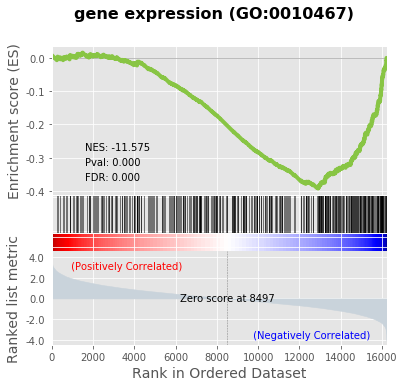

In [212]:
# to save your figure, make sure that ofname is not None
terms = pre_res_gobp.res2d.index
term_ix = 0
gseaplot(rank_metric=pre_res_gobp.ranking, term=terms[term_ix], **pre_res_gobp.results[terms[term_ix]])

# save figure
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

In [581]:
i = 10

# Print status update
t_tmp = time.time()
elapsed = float(t_tmp-t1)/60
print("performing iteration {:d} of {:d}".format(i+1,len(states)+1))
print("time elapsed: {:.2f} minutes".format(elapsed))

# Define two phenotypes for comparison    
phenotype1 =  states[i]
phenotype2 = miner.setdiff(expressionData.columns,phenotype1)

#Use Wilcoxon rank-sums to rank differential expression between phenotypes
wilcox_stats_w = []
wilcox_stats_p = []
for j in expressionData.index:
    tmp_wilcox = stats.ranksums(expressionData.loc[j,phenotype1],expressionData.loc[j,phenotype2])
    wilcox_stats_w.append(tmp_wilcox[0])
    wilcox_stats_p.append(tmp_wilcox[1])

# Produce formatted output for GSEA
rnk_st_21 = pd.DataFrame(np.vstack([wilcox_stats_w,wilcox_stats_p]).T)
rnk_st_21.index = expressionData.index
rnk_st_21.sort_values(by=0,ascending=False,inplace=True)
rnk_st_21_hgnc = miner.gene_conversion(rnk_st_21.index,id_table = id_table,list_symbols=True)
rnk_st_21.index = rnk_st_21_hgnc
rnk_st_21.to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"diff_exp.csv"])))
rnk_st_21.drop(1,axis=1,inplace=True)
rnk_st_21.head()

performing iteration 11 of 27
time elapsed: 415.89 minutes


,0
PRKAA2,4.963033
ATP8B2,4.923039
UFC1,4.849924
ACO2,4.840550
RPS6KC1,4.833052


In [583]:
t1 = time.time()
# note: multiprocessing may not work on windows; takes about 10s on MacBook Air
gs_db = 'MSigDB_Oncogenic_Signatures'
savefile = ("_").join(["State",str(state_ix),gs_db])
pre_res = gp.prerank(rnk=rnk_st_21, gene_sets=gs_db,
                     processes=20,
                     permutation_num=100, # reduce number to speed up testing
                     outdir=savefile, format='png', seed=6)
gsea_results = pre_res.res2d
# View GSEA results
gsea_results.head(10)

t2 = time.time()
print(t2-t1)

20.253164052963257


In [584]:
gsea_results.head(10)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
BCAT GDS748 UP,0.479050,2.836240,0.000000,0.031199,48,40,PKP2;GADD45G;CA2;DYNC1I1;KCTD12;SLC39A14;BAMBI...,PKP2;GADD45G;CA2;DYNC1I1;KCTD12;SLC39A14;BAMBI...
EGFR UP.V1 UP,0.405708,2.785558,0.000000,0.033279,193,172,KLF4;BACE2;COL5A2;CAPN2;RPS6KA3;DUSP6;CXADR;TA...,KLF4;BACE2;COL5A2;CAPN2;RPS6KA3;DUSP6;CXADR;TA...
RAF UP.V1 DN,0.430959,2.966831,0.000000,0.037438,194,170,PALLD;MYO10;AUTS2;MYBL1;IGF1R;SLC7A2;LRIG1;WAS...,PALLD;MYO10;AUTS2;MYBL1;IGF1R;SLC7A2;LRIG1;WAS...
ESC V6.5 UP LATE.V1 UP,0.408824,2.656640,0.000000,0.040558,190,159,GAS1;FZD2;ZNF521;PKDCC;FARP1;RASAL2;FZD8;IMPAD...,GAS1;FZD2;ZNF521;PKDCC;FARP1;RASAL2;FZD8;IMPAD...
YAP1 UP,0.410584,2.472327,0.016129,0.078442,47,37,RPN2;YWHAZ;TEAD1;SEMA3C;SNX7;SIAE;LLGL1;ARHGEF...,RPN2;YWHAZ;TEAD1;SEMA3C;SNX7;SIAE;LLGL1;ARHGEF...
SNF5 DN.V1 DN,0.401552,2.473801,0.000000,0.089436,164,132,DSG2;UCHL1;RIMKLB;TRO;SLCO3A1;CTH;PKP2;DDOST;S...,DSG2;UCHL1;RIMKLB;TRO;SLCO3A1;CTH;PKP2;DDOST;S...
PRC2 EZH2 UP.V1 DN,0.395482,2.510822,0.000000,0.089852,194,161,KLF4;VWA5A;KIAA0513;NR3C2;ATF6;SMPDL3A;TRIB1;T...,KLF4;VWA5A;KIAA0513;NR3C2;ATF6;SMPDL3A;TRIB1;T...
MEK UP.V1 UP,0.351552,2.377112,0.000000,0.102955,196,178,KLF4;LAMC1;AKR1C3;BACE2;RAI14;COL5A2;AGAP1;CAP...,KLF4;LAMC1;AKR1C3;BACE2;RAI14;COL5A2;AGAP1;CAP...
CORDENONSI YAP CONSERVED SIGNATURE,0.402991,2.338474,0.000000,0.104827,57,53,DUSP1;CRIM1;TGFB2;EMP2;DLC1;ITGB5;MDFIC;GADD45...,DUSP1;CRIM1;TGFB2;EMP2;DLC1;ITGB5;MDFIC;GADD45...


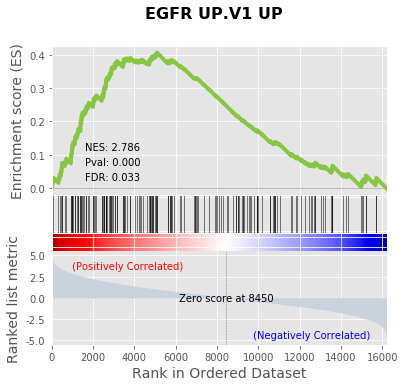

In [587]:
terms = pre_res.res2d.index
term_ix = 1
gseaplot(rank_metric=pre_res.ranking, term=terms[term_ix], **pre_res.results[terms[term_ix]])


In [184]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'Cancer_Cell_Line_Encyclopedia',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'DisGeNET',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbations_from_GEO_up',
 'Disease_Signatures_from_GEO_down_2014',
 'Disease_Signatures_from_GEO_up_2014',
 'DrugMatrix',
 'Drug_Perturbations_from_GEO_2014',
 'Drug_Perturbations

In [231]:
tfbsdb_file = os.path.join(input_path,"data","network_dictionaries","tfbsdb_tf_to_genes.pkl")
tfbsdb = miner.read_pkl(tfbsdb_file)

In [234]:

tf_symbols = miner.gene_conversion(list(tfbsdb.keys()),id_table=id_table,list_symbols=True)

In [258]:
tf_nans = np.array([i for i in range(len(tf_symbols)) if type(tf_symbols[i])==float])
tf_pass = np.array(miner.setdiff(range(len(tf_symbols)),list(tf_nans)))

symbol_list = np.array(tf_symbols)[tf_pass]
ensembl_list = np.array(tf_symbols)[tf_nans]
                        

In [259]:
def subset_survival(patients,srv):
    intersection = list(set(patients)&set(srv.index))
    tmp_srv = srv.loc[intersection,:]
    tmp_srv.sort_values(by="GuanScore",ascending=False,inplace=True)
    return tmp_srv

def check_nans(lst,pass_only=True):
    nans = [i for i in range(len(lst)) if type(lst[i])==float]
    pass_ = list(set(list(range(len(lst))))-set(nans))
    
    if pass_only is False:
        return (pass_,nans)
    return pass_

In [261]:
list(np.array(tf_symbols)[check_nans(tf_symbols)])


array(['ETS1', 'HOXA6', 'SNAI2', 'HOXA5', 'ZKSCAN3', 'NFIB', 'LEF1',
       'PARP1', 'KLF15', 'GATA4', 'MTERF1', 'LTF', 'DR1', 'NFAT5', 'HSF1',
       'THRA', 'ZNF263', 'PURA', 'HOXD9', 'LHX9', 'NR1H3', 'ESR1',
       'CREB3L1', 'POU2F1', 'HNF1B', 'PKNOX2', 'NEUROD2', 'ALX3', 'HEY1',
       'DPRX', 'BHLHE41', 'ZSCAN16', 'EBF1', 'EHF', 'KLF14', 'MAFA',
       'CTF1', 'ELF5', 'NF1', 'SCRT1', 'MEIS1', 'CTCF', 'RARA', 'HOXC11',
       'IRF1', 'STAT6', 'IRF9', 'GATA3', 'ZIC2', 'GATA5', 'LBX2', 'HOXA3',
       'HOXA1', 'HOXA11', 'FGF9', 'ZFP42', 'HOXC13', 'POU1F1', 'POU5F1',
       'POU3F2', 'FOXO4', 'MYC', 'CREB1', 'KLF7', 'HSFY1', 'PLAGL1',
       'BARX2', 'PPARG', 'PRDM1', 'FOXI1', 'ETV4', 'SMAD1', 'POU2AF1',
       'ATF4', 'NHLH1', 'ERF', 'GFI1', 'ETV5', 'RXRB', 'ZNF232',
       'GTF2IRD1', 'GLIS2', 'NFIA', 'JDP2', 'TP53', 'AR', 'ZNF740',
       'TBX2', 'MYOD1', 'HNF1A', 'DLX3', 'FOXD3', 'DBX2', 'IRX2', 'DEAF1',
       'KLF12', 'TBR1', 'HOXD8', 'GATA2', 'ZBTB16', 'FOXA1', 'MYCN',
       